***Описание проекта***

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

***Главная задача***

Обучить на этих данных лучшую модель для прогноза оттока клиентов и добиться метрики roc_auc не менее 85%.

***План работы***

- Загрузка данных

- Исследовательский анализ и предобработка данных

- Объединение данных

- Исследовательский анализ и предобработка данных объединенного датафрейма

- Подготовка данных к обучению

- Обучение моделей

- Выбор лучшей модели

- Общий вывод,рекомендации и составление отчета



In [ ]:
pip install phik

     |████████████████████████████████| 686 kB 2.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
from functools import reduce
import re
import phik
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

SEED = 251223

Для начала соберем все необходимые импорты в одном месте.

In [ ]:
contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [ ]:
tables = {'CONTRACT': contract, 'PERSONAL': personal, 'INTERNET': internet, 'PHONE': phone}
for title, table_data in tables.items():
    print(f'Информация о таблице {title}'':')
    table_data = table_data.set_index('customerID')
    display(table_data)
    table_data.info()

Информация о таблице CONTRACT:


BeginDate EndDate            Type PaperlessBilling  \
customerID                                                        
7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
5575-GNVDE  2017-04-01      No        One year               No   
3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
7795-CFOCW  2016-05-01      No        One year               No   
9237-HQITU  2019-09-01      No  Month-to-month              Yes   
...                ...     ...             ...              ...   
6840-RESVB  2018-02-01      No        One year              Yes   
2234-XADUH  2014-02-01      No        One year              Yes   
4801-JZAZL  2019-03-01      No  Month-to-month              Yes   
8361-LTMKD  2019-07-01      No  Month-to-month              Yes   
3186-AJIEK  2014-08-01      No        Two year              Yes   

                        PaymentMethod  MonthlyCharges TotalCharges  
customerID                                                          
7590-VHVEG           Electronic check           29.85        31.04  
5575-GNVDE               Mailed check           56.95      2071.84  
3668-QPYBK               Mailed check           53.85       226.17  
7795-CFOCW  Bank transfer (automatic)           42.30       1960.6  
9237-HQITU           Electronic check           70.70        353.5  
...                               ...             ...          ...  
6840-RESVB               Mailed check           84.80       2035.2  
2234-XADUH    Credit card (automatic)          103.20       7430.4  
4801-JZAZL           Electronic check           29.60        325.6  
8361-LTMKD               Mailed check           74.40        520.8  
3186-AJIEK  Bank transfer (automatic)          105.65      7251.82  

[7043 rows x 7 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB
Информация о таблице PERSONAL:


gender  SeniorCitizen Partner Dependents
customerID                                          
7590-VHVEG  Female              0     Yes         No
5575-GNVDE    Male              0      No         No
3668-QPYBK    Male              0      No         No
7795-CFOCW    Male              0      No         No
9237-HQITU  Female              0      No         No
...            ...            ...     ...        ...
6840-RESVB    Male              0     Yes        Yes
2234-XADUH  Female              0     Yes        Yes
4801-JZAZL  Female              0     Yes        Yes
8361-LTMKD    Male              1     Yes         No
3186-AJIEK    Male              0      No         No

[7043 rows x 4 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB
Информация о таблице INTERNET:


InternetService OnlineSecurity OnlineBackup DeviceProtection  \
customerID                                                                
7590-VHVEG             DSL             No          Yes               No   
5575-GNVDE             DSL            Yes           No              Yes   
3668-QPYBK             DSL            Yes          Yes               No   
7795-CFOCW             DSL            Yes           No              Yes   
9237-HQITU     Fiber optic             No           No               No   
...                    ...            ...          ...              ...   
6840-RESVB             DSL            Yes           No              Yes   
2234-XADUH     Fiber optic             No          Yes              Yes   
4801-JZAZL             DSL            Yes           No               No   
8361-LTMKD     Fiber optic             No           No               No   
3186-AJIEK     Fiber optic            Yes           No              Yes   

           TechSupport StreamingTV StreamingMovies  
customerID                                          
7590-VHVEG          No          No              No  
5575-GNVDE          No          No              No  
3668-QPYBK          No          No              No  
7795-CFOCW         Yes          No              No  
9237-HQITU          No          No              No  
...                ...         ...             ...  
6840-RESVB         Yes         Yes             Yes  
2234-XADUH          No         Yes             Yes  
4801-JZAZL          No          No              No  
8361-LTMKD          No          No              No  
3186-AJIEK         Yes         Yes             Yes  

[5517 rows x 7 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB
Информация о таблице PHONE:


MultipleLines
customerID              
5575-GNVDE            No
3668-QPYBK            No
9237-HQITU            No
9305-CDSKC           Yes
1452-KIOVK           Yes
...                  ...
2569-WGERO            No
6840-RESVB           Yes
2234-XADUH           Yes
8361-LTMKD           Yes
3186-AJIEK            No

[6361 rows x 1 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


Визуально знакомимся с данными.

Основные выводы на данном этапе:

1.Необходимо перевести названия столбцов к правильному формату для удобства.

2.В таблице Phone меньше строк, чем в таблицах Contract и Personal. Также еще меньше строк в таблице Internet. Это говорит о том, что не все клиенты используют оба вида услуг - интернет + телефония.

3.Также некоторые типы данных лучше изменить для удобства и подготовки модели. Они будут представлены ниже.

4.Заполнить пропуски.

5.Создать новые признаки.

Все это исправим дальше после объединения таблиц.


In [ ]:
data_tables = [contract, internet, personal, phone]
data = reduce(lambda left,right: pd.merge(left ,right, on=['customerID'],
                                            how='outer'), data_tables)
display(data)
data.info()

customerID   BeginDate EndDate            Type PaperlessBilling  \
0     7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1     5575-GNVDE  2017-04-01      No        One year               No   
2     3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3     7795-CFOCW  2016-05-01      No        One year               No   
4     9237-HQITU  2019-09-01      No  Month-to-month              Yes   
...          ...         ...     ...             ...              ...   
7038  6840-RESVB  2018-02-01      No        One year              Yes   
7039  2234-XADUH  2014-02-01      No        One year              Yes   
7040  4801-JZAZL  2019-03-01      No  Month-to-month              Yes   
7041  8361-LTMKD  2019-07-01      No  Month-to-month              Yes   
7042  3186-AJIEK  2014-08-01      No        Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges InternetService  \
0              Electronic check           29.85        31.04             DSL   
1                  Mailed check           56.95      2071.84             DSL   
2                  Mailed check           53.85       226.17             DSL   
3     Bank transfer (automatic)           42.30       1960.6             DSL   
4              Electronic check           70.70        353.5     Fiber optic   
...                         ...             ...          ...             ...   
7038               Mailed check           84.80       2035.2             DSL   
7039    Credit card (automatic)          103.20       7430.4     Fiber optic   
7040           Electronic check           29.60        325.6             DSL   
7041               Mailed check           74.40        520.8     Fiber optic   
7042  Bank transfer (automatic)          105.65      7251.82     Fiber optic   

     OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0                No          Yes               No          No          No   
1               Yes           No              Yes          No          No   
2               Yes          Yes               No          No          No   
3               Yes           No              Yes         Yes          No   
4                No           No               No          No          No   
...             ...          ...              ...         ...         ...   
7038            Yes           No              Yes         Yes         Yes   
7039             No          Yes              Yes          No         Yes   
7040            Yes           No               No          No          No   
7041             No           No               No          No          No   
7042            Yes           No              Yes         Yes         Yes   

     StreamingMovies  gender  SeniorCitizen Partner Dependents MultipleLines  
0                 No  Female              0     Yes         No           NaN  
1                 No    Male              0      No         No            No  
2                 No    Male              0      No         No            No  
3                 No    Male              0      No         No           NaN  
4                 No  Female              0      No         No            No  
...              ...     ...            ...     ...        ...           ...  
7038             Yes    Male              0     Yes        Yes           Yes  
7039             Yes  Female              0     Yes        Yes           Yes  
7040              No  Female              0     Yes        Yes           NaN  
7041              No    Male              1     Yes         No           Yes  
7042             Yes    Male              0      No         No            No  

[7043 rows x 20 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [ ]:
def camel_case(column_name):
    first_pass = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', first_pass).lower()

def snake_case(df):
    new_columns = [camel_case(column) for column in df.columns]
    df.columns = new_columns
    return df

data = snake_case(data)
display(data)

customer_id  begin_date end_date            type paperless_billing  \
0     7590-VHVEG  2020-01-01       No  Month-to-month               Yes   
1     5575-GNVDE  2017-04-01       No        One year                No   
2     3668-QPYBK  2019-10-01       No  Month-to-month               Yes   
3     7795-CFOCW  2016-05-01       No        One year                No   
4     9237-HQITU  2019-09-01       No  Month-to-month               Yes   
...          ...         ...      ...             ...               ...   
7038  6840-RESVB  2018-02-01       No        One year               Yes   
7039  2234-XADUH  2014-02-01       No        One year               Yes   
7040  4801-JZAZL  2019-03-01       No  Month-to-month               Yes   
7041  8361-LTMKD  2019-07-01       No  Month-to-month               Yes   
7042  3186-AJIEK  2014-08-01       No        Two year               Yes   

                 payment_method  monthly_charges total_charges  \
0              Electronic check            29.85         31.04   
1                  Mailed check            56.95       2071.84   
2                  Mailed check            53.85        226.17   
3     Bank transfer (automatic)            42.30        1960.6   
4              Electronic check            70.70         353.5   
...                         ...              ...           ...   
7038               Mailed check            84.80        2035.2   
7039    Credit card (automatic)           103.20        7430.4   
7040           Electronic check            29.60         325.6   
7041               Mailed check            74.40         520.8   
7042  Bank transfer (automatic)           105.65       7251.82   

     internet_service online_security online_backup device_protection  \
0                 DSL              No           Yes                No   
1                 DSL             Yes            No               Yes   
2                 DSL             Yes           Yes                No   
3                 DSL             Yes            No               Yes   
4         Fiber optic              No            No                No   
...               ...             ...           ...               ...   
7038              DSL             Yes            No               Yes   
7039      Fiber optic              No           Yes               Yes   
7040              DSL             Yes            No                No   
7041      Fiber optic              No            No                No   
7042      Fiber optic             Yes            No               Yes   

     tech_support streaming_tv streaming_movies  gender  senior_citizen  \
0              No           No               No  Female               0   
1              No           No               No    Male               0   
2              No           No               No    Male               0   
3             Yes           No               No    Male               0   
4              No           No               No  Female               0   
...           ...          ...              ...     ...             ...   
7038          Yes          Yes              Yes    Male               0   
7039           No          Yes              Yes  Female               0   
7040           No           No               No  Female               0   
7041           No           No               No    Male               1   
7042          Yes          Yes              Yes    Male               0   

     partner dependents multiple_lines  
0        Yes         No            NaN  
1         No         No             No  
2         No         No             No  
3         No         No            NaN  
4         No         No             No  
...      ...        ...            ...  
7038     Yes        Yes            Yes  
7039     Yes        Yes            Yes  
7040     Yes        Yes            NaN  
7041     Yes         No            Yes  
7042      No         No             No  

[7043 rows x 20 columns]

Привели названия столбцов к правильному формату.

Теперь создадим целевой признак target - он зависит от столбца end_date: если в нем стоит No, то клиент все еще в компании(1), если стоит дата - он ушел(0).

In [ ]:
data['target'] = (data['end_date'] == 'No').astype(int)
print(data['target'].value_counts())
data.head(10)

1    5942
0    1101
Name: target, dtype: int64


customer_id  begin_date    end_date            type paperless_billing  \
0  7590-VHVEG  2020-01-01          No  Month-to-month               Yes   
1  5575-GNVDE  2017-04-01          No        One year                No   
2  3668-QPYBK  2019-10-01          No  Month-to-month               Yes   
3  7795-CFOCW  2016-05-01          No        One year                No   
4  9237-HQITU  2019-09-01          No  Month-to-month               Yes   
5  9305-CDSKC  2019-03-01          No  Month-to-month               Yes   
6  1452-KIOVK  2018-04-01          No  Month-to-month               Yes   
7  6713-OKOMC  2019-04-01          No  Month-to-month                No   
8  7892-POOKP  2017-07-01          No  Month-to-month               Yes   
9  6388-TABGU  2014-12-01  2017-05-01        One year                No   

              payment_method  monthly_charges total_charges internet_service  \
0           Electronic check            29.85         31.04              DSL   
1               Mailed check            56.95       2071.84              DSL   
2               Mailed check            53.85        226.17              DSL   
3  Bank transfer (automatic)            42.30        1960.6              DSL   
4           Electronic check            70.70         353.5      Fiber optic   
5           Electronic check            99.65       1150.96      Fiber optic   
6    Credit card (automatic)            89.10       2058.21      Fiber optic   
7               Mailed check            29.75        300.48              DSL   
8           Electronic check           104.80       3573.68      Fiber optic   
9  Bank transfer (automatic)            56.15       1628.35              DSL   

  online_security  ... device_protection tech_support streaming_tv  \
0              No  ...                No           No           No   
1             Yes  ...               Yes           No           No   
2             Yes  ...                No           No           No   
3             Yes  ...               Yes          Yes           No   
4              No  ...                No           No           No   
5              No  ...               Yes           No          Yes   
6              No  ...                No           No          Yes   
7             Yes  ...                No           No           No   
8              No  ...               Yes          Yes          Yes   
9             Yes  ...                No           No           No   

  streaming_movies  gender senior_citizen  partner dependents multiple_lines  \
0               No  Female              0      Yes         No            NaN   
1               No    Male              0       No         No             No   
2               No    Male              0       No         No             No   
3               No    Male              0       No         No            NaN   
4               No  Female              0       No         No             No   
5              Yes  Female              0       No         No            Yes   
6               No    Male              0       No        Yes            Yes   
7               No  Female              0       No         No            NaN   
8              Yes  Female              0      Yes         No            Yes   
9               No    Male              0       No        Yes             No   

  target  
0      1  
1      1  
2      1  
3      1  
4      1  
5      1  
6      1  
7      1  
8      1  
9      0  

[10 rows x 21 columns]

Теперь поменяем No в столбце end_date на последнюю актуальную дату - 2020.02.01.

In [ ]:
data['end_date'] = data['end_date'].replace('No', '2020-02-01')
data.head(10)

customer_id  begin_date    end_date            type paperless_billing  \
0  7590-VHVEG  2020-01-01  2020-02-01  Month-to-month               Yes   
1  5575-GNVDE  2017-04-01  2020-02-01        One year                No   
2  3668-QPYBK  2019-10-01  2020-02-01  Month-to-month               Yes   
3  7795-CFOCW  2016-05-01  2020-02-01        One year                No   
4  9237-HQITU  2019-09-01  2020-02-01  Month-to-month               Yes   
5  9305-CDSKC  2019-03-01  2020-02-01  Month-to-month               Yes   
6  1452-KIOVK  2018-04-01  2020-02-01  Month-to-month               Yes   
7  6713-OKOMC  2019-04-01  2020-02-01  Month-to-month                No   
8  7892-POOKP  2017-07-01  2020-02-01  Month-to-month               Yes   
9  6388-TABGU  2014-12-01  2017-05-01        One year                No   

              payment_method  monthly_charges total_charges internet_service  \
0           Electronic check            29.85         31.04              DSL   
1               Mailed check            56.95       2071.84              DSL   
2               Mailed check            53.85        226.17              DSL   
3  Bank transfer (automatic)            42.30        1960.6              DSL   
4           Electronic check            70.70         353.5      Fiber optic   
5           Electronic check            99.65       1150.96      Fiber optic   
6    Credit card (automatic)            89.10       2058.21      Fiber optic   
7               Mailed check            29.75        300.48              DSL   
8           Electronic check           104.80       3573.68      Fiber optic   
9  Bank transfer (automatic)            56.15       1628.35              DSL   

  online_security  ... device_protection tech_support streaming_tv  \
0              No  ...                No           No           No   
1             Yes  ...               Yes           No           No   
2             Yes  ...                No           No           No   
3             Yes  ...               Yes          Yes           No   
4              No  ...                No           No           No   
5              No  ...               Yes           No          Yes   
6              No  ...                No           No          Yes   
7             Yes  ...                No           No           No   
8              No  ...               Yes          Yes          Yes   
9             Yes  ...                No           No           No   

  streaming_movies  gender senior_citizen  partner dependents multiple_lines  \
0               No  Female              0      Yes         No            NaN   
1               No    Male              0       No         No             No   
2               No    Male              0       No         No             No   
3               No    Male              0       No         No            NaN   
4               No  Female              0       No         No             No   
5              Yes  Female              0       No         No            Yes   
6               No    Male              0       No        Yes            Yes   
7               No  Female              0       No         No            NaN   
8              Yes  Female              0      Yes         No            Yes   
9               No    Male              0       No        Yes             No   

  target  
0      1  
1      1  
2      1  
3      1  
4      1  
5      1  
6      1  
7      1  
8      1  
9      0  

[10 rows x 21 columns]

In [ ]:
data[['begin_date', 'end_date']] = data[['begin_date', 'end_date']].apply(pd.to_datetime)
print(data.dtypes)
data

customer_id                  object
begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges                object
internet_service             object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
multiple_lines               object
target                        int64
dtype: object


customer_id begin_date   end_date            type paperless_billing  \
0     7590-VHVEG 2020-01-01 2020-02-01  Month-to-month               Yes   
1     5575-GNVDE 2017-04-01 2020-02-01        One year                No   
2     3668-QPYBK 2019-10-01 2020-02-01  Month-to-month               Yes   
3     7795-CFOCW 2016-05-01 2020-02-01        One year                No   
4     9237-HQITU 2019-09-01 2020-02-01  Month-to-month               Yes   
...          ...        ...        ...             ...               ...   
7038  6840-RESVB 2018-02-01 2020-02-01        One year               Yes   
7039  2234-XADUH 2014-02-01 2020-02-01        One year               Yes   
7040  4801-JZAZL 2019-03-01 2020-02-01  Month-to-month               Yes   
7041  8361-LTMKD 2019-07-01 2020-02-01  Month-to-month               Yes   
7042  3186-AJIEK 2014-08-01 2020-02-01        Two year               Yes   

                 payment_method  monthly_charges total_charges  \
0              Electronic check            29.85         31.04   
1                  Mailed check            56.95       2071.84   
2                  Mailed check            53.85        226.17   
3     Bank transfer (automatic)            42.30        1960.6   
4              Electronic check            70.70         353.5   
...                         ...              ...           ...   
7038               Mailed check            84.80        2035.2   
7039    Credit card (automatic)           103.20        7430.4   
7040           Electronic check            29.60         325.6   
7041               Mailed check            74.40         520.8   
7042  Bank transfer (automatic)           105.65       7251.82   

     internet_service online_security  ... device_protection tech_support  \
0                 DSL              No  ...                No           No   
1                 DSL             Yes  ...               Yes           No   
2                 DSL             Yes  ...                No           No   
3                 DSL             Yes  ...               Yes          Yes   
4         Fiber optic              No  ...                No           No   
...               ...             ...  ...               ...          ...   
7038              DSL             Yes  ...               Yes          Yes   
7039      Fiber optic              No  ...               Yes           No   
7040              DSL             Yes  ...                No           No   
7041      Fiber optic              No  ...                No           No   
7042      Fiber optic             Yes  ...               Yes          Yes   

     streaming_tv streaming_movies  gender senior_citizen  partner dependents  \
0              No               No  Female              0      Yes         No   
1              No               No    Male              0       No         No   
2              No               No    Male              0       No         No   
3              No               No    Male              0       No         No   
4              No               No  Female              0       No         No   
...           ...              ...     ...            ...      ...        ...   
7038          Yes              Yes    Male              0      Yes        Yes   
7039          Yes              Yes  Female              0      Yes        Yes   
7040           No               No  Female              0      Yes        Yes   
7041           No               No    Male              1      Yes         No   
7042          Yes              Yes    Male              0       No         No   

     multiple_lines target  
0               NaN      1  
1                No      1  
2                No      1  
3               NaN      1  
4                No      1  
...             ...    ...  
7038            Yes      1  
7039            Yes      1  
7040            NaN      1  
7041            Yes      1  
7042             No      1  

[7043 rows x 21 columns]

В столбце total_charge нужно поменять тип данных с object на float64.

In [ ]:
data['total_charges'] = pd.to_numeric(data['total_charges'], errors ='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   internet_service   5517 non-null   object        
 9   online_security    5517 non-null   object        
 10  online_backup      5517 non-null   object        
 11  device_protection  5517 non-null   object        
 12  tech_support       5517 non-null   object        
 13  streaming_tv       5517 non-null   object        
 14  streamin

In [ ]:
print('Пропусков в столбце total_charges:', data['total_charges'].isna().sum())
data[data['total_charges'].isnull()]

Пропусков в столбце total_charges: 11


customer_id begin_date   end_date      type paperless_billing  \
488   4472-LVYGI 2020-02-01 2020-02-01  Two year               Yes   
753   3115-CZMZD 2020-02-01 2020-02-01  Two year                No   
936   5709-LVOEQ 2020-02-01 2020-02-01  Two year                No   
1082  4367-NUYAO 2020-02-01 2020-02-01  Two year                No   
1340  1371-DWPAZ 2020-02-01 2020-02-01  Two year                No   
3331  7644-OMVMY 2020-02-01 2020-02-01  Two year                No   
3826  3213-VVOLG 2020-02-01 2020-02-01  Two year                No   
4380  2520-SGTTA 2020-02-01 2020-02-01  Two year                No   
5218  2923-ARZLG 2020-02-01 2020-02-01  One year               Yes   
6670  4075-WKNIU 2020-02-01 2020-02-01  Two year                No   
6754  2775-SEFEE 2020-02-01 2020-02-01  Two year               Yes   

                 payment_method  monthly_charges  total_charges  \
488   Bank transfer (automatic)            52.55            NaN   
753                Mailed check            20.25            NaN   
936                Mailed check            80.85            NaN   
1082               Mailed check            25.75            NaN   
1340    Credit card (automatic)            56.05            NaN   
3331               Mailed check            19.85            NaN   
3826               Mailed check            25.35            NaN   
4380               Mailed check            20.00            NaN   
5218               Mailed check            19.70            NaN   
6670               Mailed check            73.35            NaN   
6754  Bank transfer (automatic)            61.90            NaN   

     internet_service online_security  ... device_protection tech_support  \
488               DSL             Yes  ...               Yes          Yes   
753               NaN             NaN  ...               NaN          NaN   
936               DSL             Yes  ...               Yes           No   
1082              NaN             NaN  ...               NaN          NaN   
1340              DSL             Yes  ...               Yes          Yes   
3331              NaN             NaN  ...               NaN          NaN   
3826              NaN             NaN  ...               NaN          NaN   
4380              NaN             NaN  ...               NaN          NaN   
5218              NaN             NaN  ...               NaN          NaN   
6670              DSL              No  ...               Yes          Yes   
6754              DSL             Yes  ...                No          Yes   

     streaming_tv streaming_movies  gender senior_citizen  partner dependents  \
488           Yes               No  Female              0      Yes        Yes   
753           NaN              NaN    Male              0       No        Yes   
936           Yes              Yes  Female              0      Yes        Yes   
1082          NaN              NaN    Male              0      Yes        Yes   
1340          Yes               No  Female              0      Yes        Yes   
3331          NaN              NaN    Male              0      Yes        Yes   
3826          NaN              NaN    Male              0      Yes        Yes   
4380          NaN              NaN  Female              0      Yes        Yes   
5218          NaN              NaN    Male              0      Yes        Yes   
6670          Yes               No  Female              0      Yes        Yes   
6754           No               No    Male              0       No        Yes   

     multiple_lines target  
488             NaN      1  
753              No      1  
936              No      1  
1082            Yes      1  
1340            NaN      1  
3331             No      1  
3826            Yes      1  
4380             No      1  
5218             No      1  
6670            Yes      1  
6754            Yes      1  

[11 rows x 21 columns]

In [ ]:
data['total_charges'].fillna(data[data['total_charges'].isnull()]['monthly_charges'],
                                          inplace = True)
data['total_charges'].isna().sum()

0

Все пропущенные значения стоят у новых клиентов, поэтому заменим эти пропуски на значение месячного платежа.

Создадим новый столбец - продолжительность пользования услугами компании в днях. Столбцы с датами удалим - они не нужны для обучения модели.

In [ ]:
data['duration'] = (data['end_date'] - data['begin_date']).dt.days
data = data.drop(['begin_date', 'end_date'], axis=1)
data

customer_id            type paperless_billing             payment_method  \
0     7590-VHVEG  Month-to-month               Yes           Electronic check   
1     5575-GNVDE        One year                No               Mailed check   
2     3668-QPYBK  Month-to-month               Yes               Mailed check   
3     7795-CFOCW        One year                No  Bank transfer (automatic)   
4     9237-HQITU  Month-to-month               Yes           Electronic check   
...          ...             ...               ...                        ...   
7038  6840-RESVB        One year               Yes               Mailed check   
7039  2234-XADUH        One year               Yes    Credit card (automatic)   
7040  4801-JZAZL  Month-to-month               Yes           Electronic check   
7041  8361-LTMKD  Month-to-month               Yes               Mailed check   
7042  3186-AJIEK        Two year               Yes  Bank transfer (automatic)   

      monthly_charges  total_charges internet_service online_security  \
0               29.85          31.04              DSL              No   
1               56.95        2071.84              DSL             Yes   
2               53.85         226.17              DSL             Yes   
3               42.30        1960.60              DSL             Yes   
4               70.70         353.50      Fiber optic              No   
...               ...            ...              ...             ...   
7038            84.80        2035.20              DSL             Yes   
7039           103.20        7430.40      Fiber optic              No   
7040            29.60         325.60              DSL             Yes   
7041            74.40         520.80      Fiber optic              No   
7042           105.65        7251.82      Fiber optic             Yes   

     online_backup device_protection tech_support streaming_tv  \
0              Yes                No           No           No   
1               No               Yes           No           No   
2              Yes                No           No           No   
3               No               Yes          Yes           No   
4               No                No           No           No   
...            ...               ...          ...          ...   
7038            No               Yes          Yes          Yes   
7039           Yes               Yes           No          Yes   
7040            No                No           No           No   
7041            No                No           No           No   
7042            No               Yes          Yes          Yes   

     streaming_movies  gender  senior_citizen partner dependents  \
0                  No  Female               0     Yes         No   
1                  No    Male               0      No         No   
2                  No    Male               0      No         No   
3                  No    Male               0      No         No   
4                  No  Female               0      No         No   
...               ...     ...             ...     ...        ...   
7038              Yes    Male               0     Yes        Yes   
7039              Yes  Female               0     Yes        Yes   
7040               No  Female               0     Yes        Yes   
7041               No    Male               1     Yes         No   
7042              Yes    Male               0      No         No   

     multiple_lines  target  duration  
0               NaN       1        31  
1                No       1      1036  
2                No       1       123  
3               NaN       1      1371  
4                No       1       153  
...             ...     ...       ...  
7038            Yes       1       730  
7039            Yes       1      2191  
7040            NaN       1       337  
7041            Yes       1       215  
7042             No       1      2010  

[7043 rows x 20 columns]

В столбце senior_citizen заменим 0 и 1 на Yes и No, так как наличие пенсионного возраста - это категориальный признак.

In [ ]:
data['senior_citizen'] = data['senior_citizen'].map({0: 'No', 1: 'Yes'})
data.info()
data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   internet_service   5517 non-null   object 
 7   online_security    5517 non-null   object 
 8   online_backup      5517 non-null   object 
 9   device_protection  5517 non-null   object 
 10  tech_support       5517 non-null   object 
 11  streaming_tv       5517 non-null   object 
 12  streaming_movies   5517 non-null   object 
 13  gender             7043 non-null   object 
 14  senior_citizen     7043 non-null   object 
 15  partner            7043 non-null   object 
 16  dependents         7043 

customer_id            type paperless_billing             payment_method  \
0     7590-VHVEG  Month-to-month               Yes           Electronic check   
1     5575-GNVDE        One year                No               Mailed check   
2     3668-QPYBK  Month-to-month               Yes               Mailed check   
3     7795-CFOCW        One year                No  Bank transfer (automatic)   
4     9237-HQITU  Month-to-month               Yes           Electronic check   
...          ...             ...               ...                        ...   
7038  6840-RESVB        One year               Yes               Mailed check   
7039  2234-XADUH        One year               Yes    Credit card (automatic)   
7040  4801-JZAZL  Month-to-month               Yes           Electronic check   
7041  8361-LTMKD  Month-to-month               Yes               Mailed check   
7042  3186-AJIEK        Two year               Yes  Bank transfer (automatic)   

      monthly_charges  total_charges internet_service online_security  \
0               29.85          31.04              DSL              No   
1               56.95        2071.84              DSL             Yes   
2               53.85         226.17              DSL             Yes   
3               42.30        1960.60              DSL             Yes   
4               70.70         353.50      Fiber optic              No   
...               ...            ...              ...             ...   
7038            84.80        2035.20              DSL             Yes   
7039           103.20        7430.40      Fiber optic              No   
7040            29.60         325.60              DSL             Yes   
7041            74.40         520.80      Fiber optic              No   
7042           105.65        7251.82      Fiber optic             Yes   

     online_backup device_protection tech_support streaming_tv  \
0              Yes                No           No           No   
1               No               Yes           No           No   
2              Yes                No           No           No   
3               No               Yes          Yes           No   
4               No                No           No           No   
...            ...               ...          ...          ...   
7038            No               Yes          Yes          Yes   
7039           Yes               Yes           No          Yes   
7040            No                No           No           No   
7041            No                No           No           No   
7042            No               Yes          Yes          Yes   

     streaming_movies  gender senior_citizen partner dependents  \
0                  No  Female             No     Yes         No   
1                  No    Male             No      No         No   
2                  No    Male             No      No         No   
3                  No    Male             No      No         No   
4                  No  Female             No      No         No   
...               ...     ...            ...     ...        ...   
7038              Yes    Male             No     Yes        Yes   
7039              Yes  Female             No     Yes        Yes   
7040               No  Female             No     Yes        Yes   
7041               No    Male            Yes     Yes         No   
7042              Yes    Male             No      No         No   

     multiple_lines  target  duration  
0               NaN       1        31  
1                No       1      1036  
2                No       1       123  
3               NaN       1      1371  
4                No       1       153  
...             ...     ...       ...  
7038            Yes       1       730  
7039            Yes       1      2191  
7040            NaN       1       337  
7041            Yes       1       215  
7042             No       1      2010  

[7043 rows x 20 columns]

In [ ]:
data.isna().sum()

customer_id             0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines        682
target                  0
duration                0
dtype: int64

Все эти пропуски мы можем заполнить заглушкой No internet и No phone.


In [ ]:
columns_to_replace = ['internet_service', 'online_security', 'online_backup',
                      'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

for column in columns_to_replace:
    data[column] = data[column].replace(np.nan, 'No internet', regex=True)

data.info()
data['internet_service'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   internet_service   7043 non-null   object 
 7   online_security    7043 non-null   object 
 8   online_backup      7043 non-null   object 
 9   device_protection  7043 non-null   object 
 10  tech_support       7043 non-null   object 
 11  streaming_tv       7043 non-null   object 
 12  streaming_movies   7043 non-null   object 
 13  gender             7043 non-null   object 
 14  senior_citizen     7043 non-null   object 
 15  partner            7043 non-null   object 
 16  dependents         7043 

Fiber optic    3096
DSL            2421
No internet    1526
Name: internet_service, dtype: int64

In [ ]:
data['multiple_lines'] = data['multiple_lines'].fillna('No phone')
data.info()
data['multiple_lines'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   internet_service   7043 non-null   object 
 7   online_security    7043 non-null   object 
 8   online_backup      7043 non-null   object 
 9   device_protection  7043 non-null   object 
 10  tech_support       7043 non-null   object 
 11  streaming_tv       7043 non-null   object 
 12  streaming_movies   7043 non-null   object 
 13  gender             7043 non-null   object 
 14  senior_citizen     7043 non-null   object 
 15  partner            7043 non-null   object 
 16  dependents         7043 

No          3390
Yes         2971
No phone     682
Name: multiple_lines, dtype: int64

In [ ]:
data.duplicated().sum()

0

Дубликаты отсутствуют.

***ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ***

In [ ]:
data['target'].value_counts()

1    5942
0    1101
Name: target, dtype: int64

В датасете есть дисбаланс классов - соотношение примерно 5:1.

Теперь посмотрим на распределения данных.

In [ ]:
data = data.set_index('customer_id')

In [ ]:
cat_features = []
num_features = []
for i in data.columns:
    if data[i].dtype == 'object':
        cat_features.append(i)
    elif data[i].dtype == 'float64' or data[i].dtype == 'int':
        num_features.append(i)
print(cat_features, num_features)

['type', 'paperless_billing', 'payment_method', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines'] ['monthly_charges', 'total_charges', 'target', 'duration']


In [ ]:
num_features.remove('target')

In [ ]:
num_features

['monthly_charges', 'total_charges', 'duration']

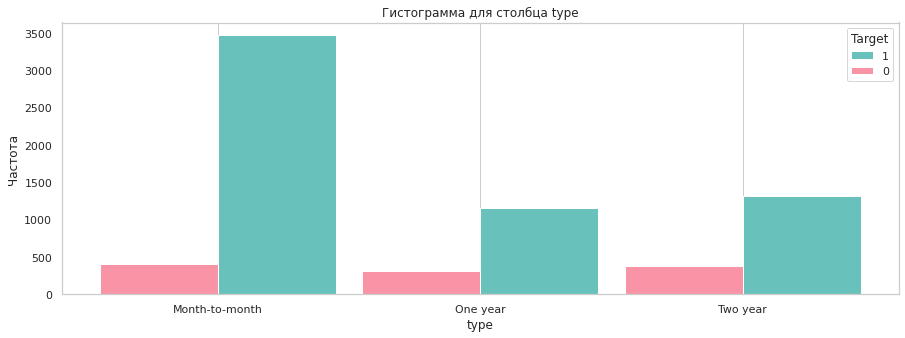

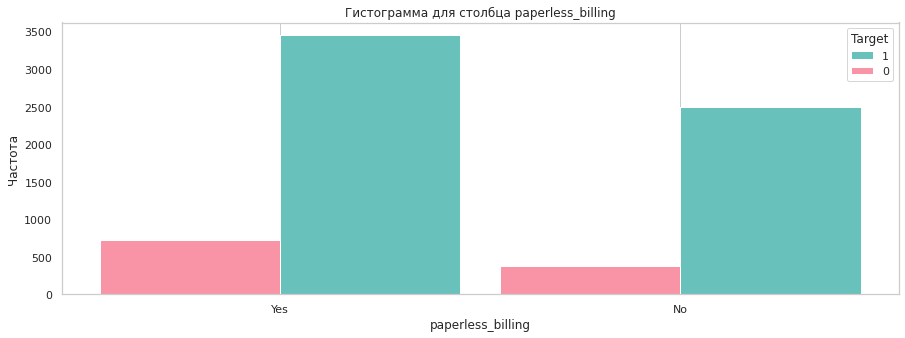

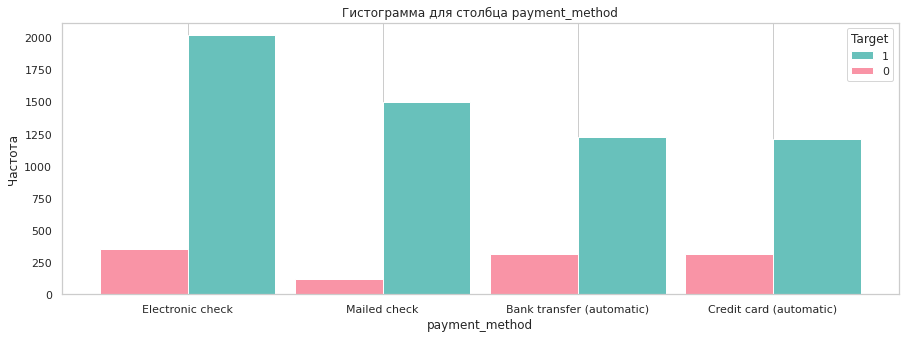

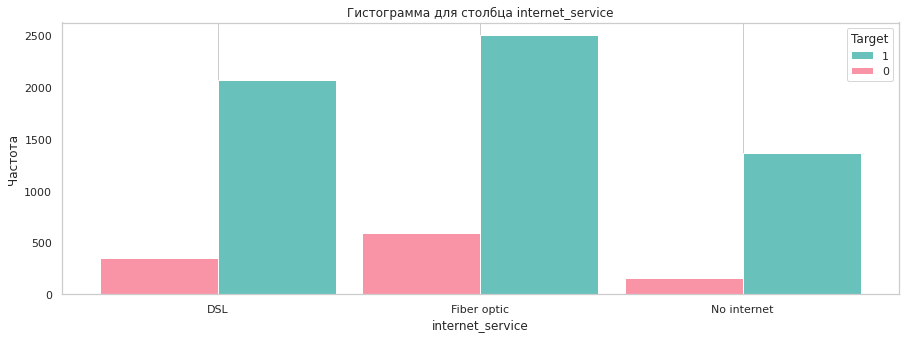

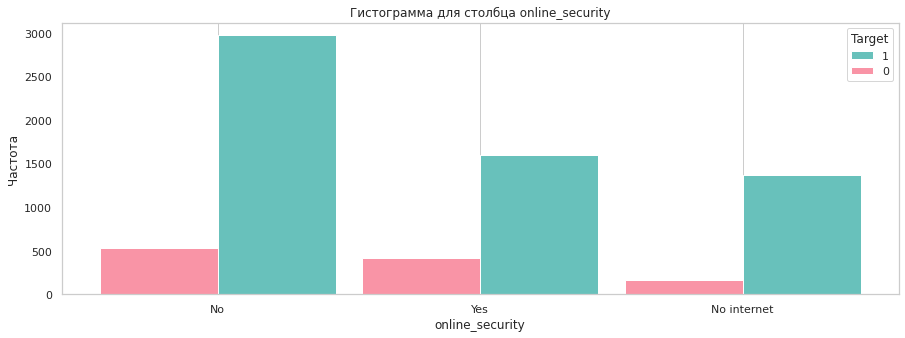

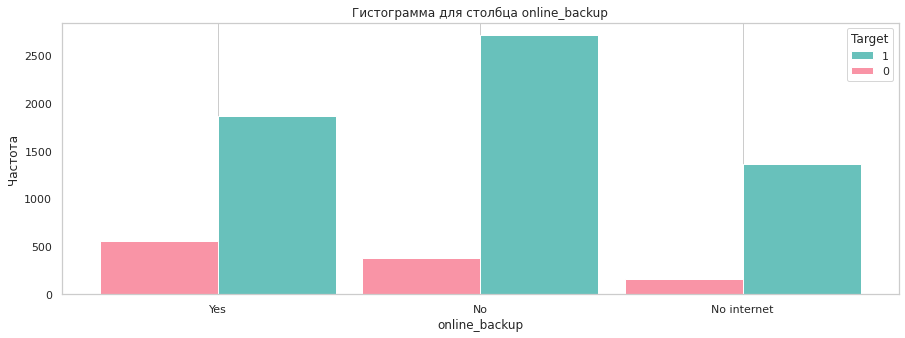

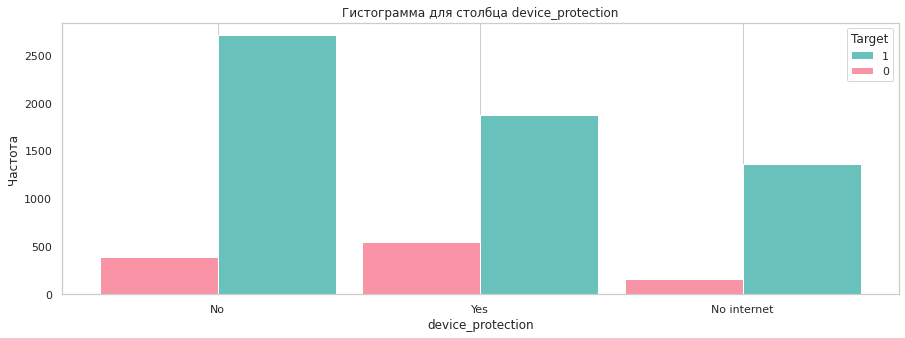

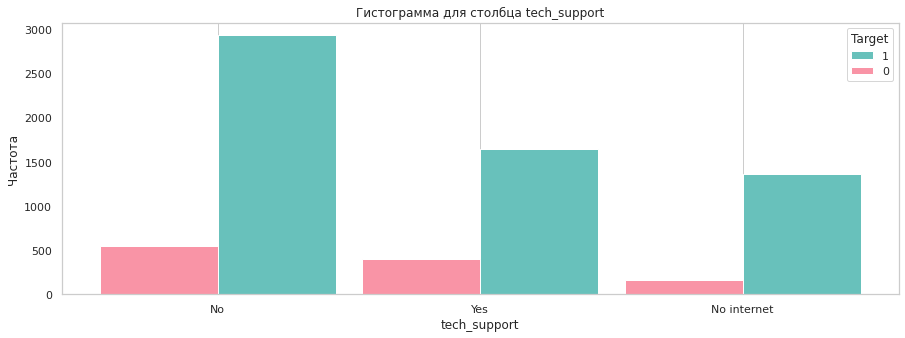

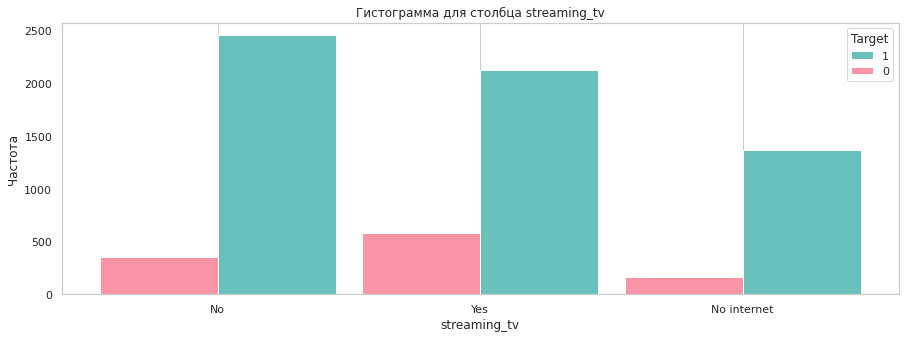

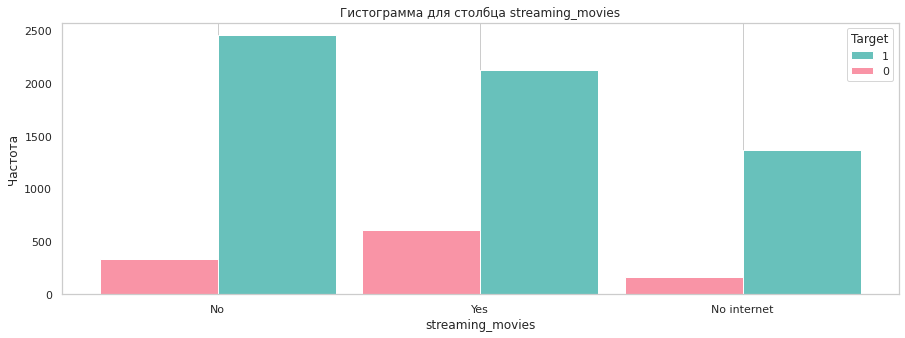

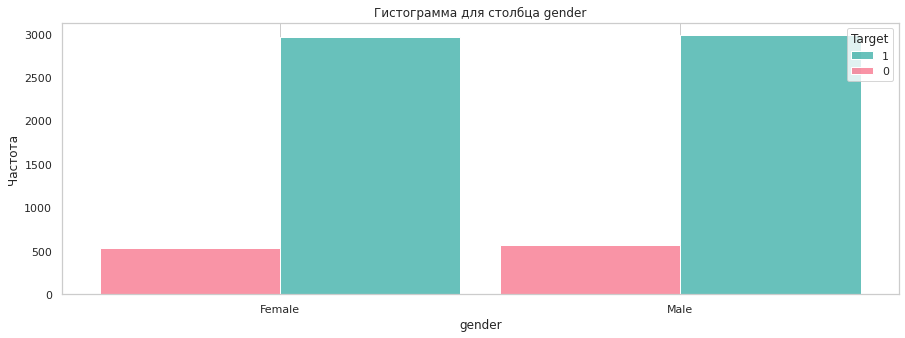

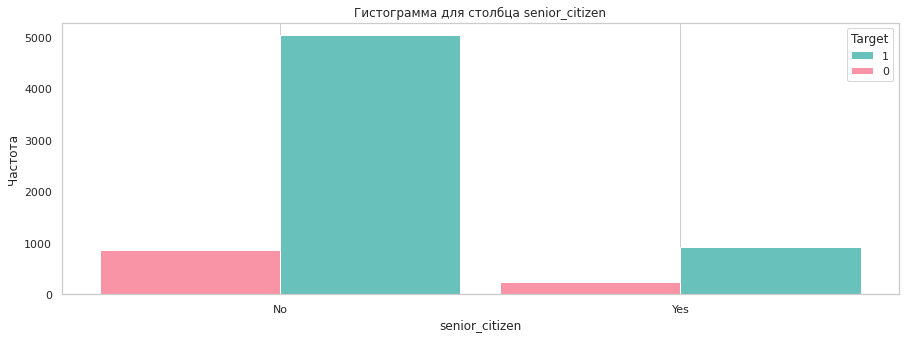

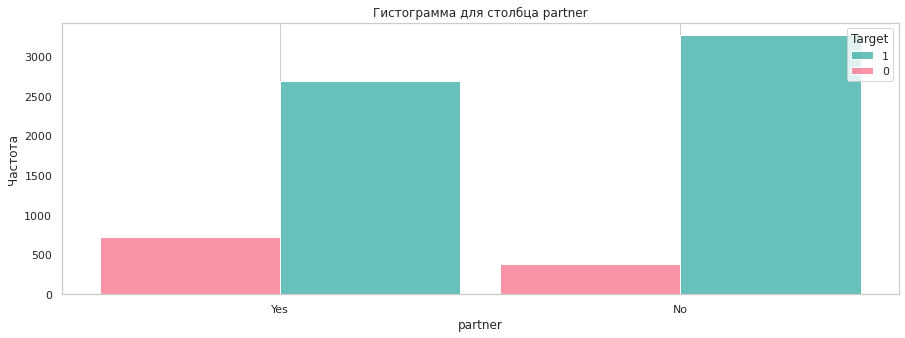

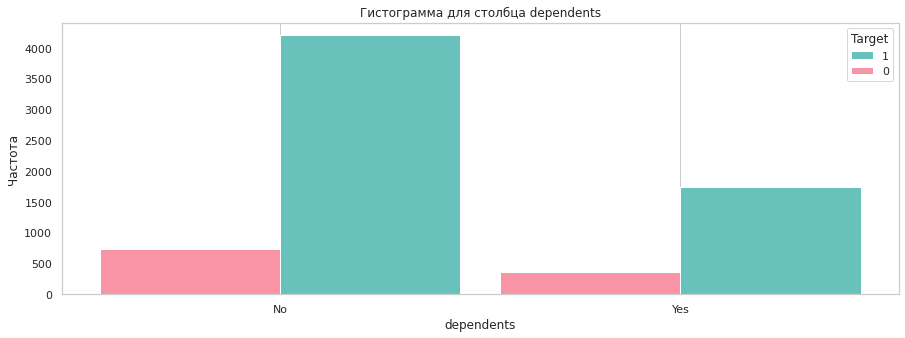

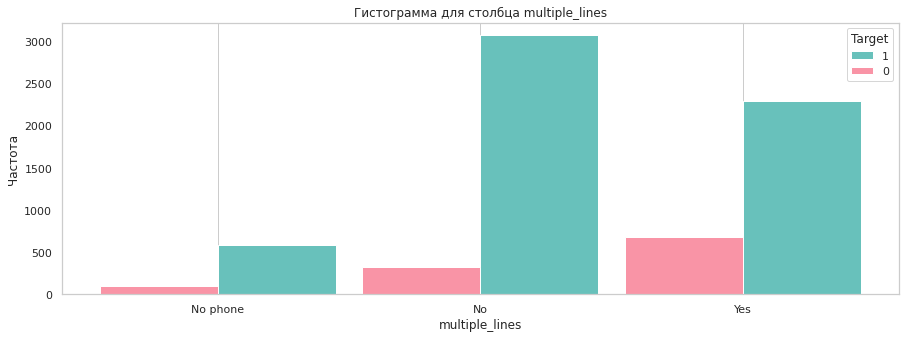

In [ ]:
sns.set(style="whitegrid", palette="pastel")
palette = sns.color_palette("husl", n_colors=len(data['target'].unique()))
for i in cat_features:
    plt.figure(figsize=(15, 5))
    sns.histplot(data=data, x=i, hue='target', multiple="dodge", shrink=.9, palette=palette)
    plt.ylabel('Частота')
    plt.xlabel(i)
    plt.title(f'Гистограмма для столбца {i}')
    plt.legend(title='Target', loc='upper right', labels=data['target'].unique())
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

- Люди, которые платят сразу на год или два - реже уходят. Месячную подписку легко отменить, а вот разрывать долгосрочный договор и возвращать деньги обратно всегда сложнее.

- Люди, которые платят наличными - реже уходят. Вероятно, так оплачивают люди выше среднего возраста и пенсионеры. Такие люди также склонны реже что-то менять в своей жизни.

- Люди, которые оплачивают автоматически с банковского перевода или кредитной карты - реже уходят. Это может быть связано с удобством или забыванием "отключить услугу".

- Чаще всего уходят люди, у которых нет дополнительных интернет-услуг.

- Среди тех, кто пользуется телефонией - чаще уходят те,у кого возможно подключение нескольких каналов. Возможно, это связано с плохим качеством телефонной связи.

- Гендер практически не влияет на уход.

- Среди тех, кто ушел - большинство не являются пенсионерами, не имеют супругов, не имеют детей. Скорее всего, это молодые люди.


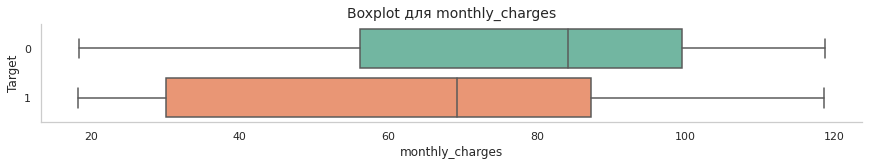

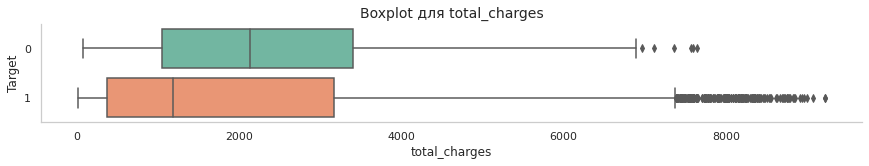

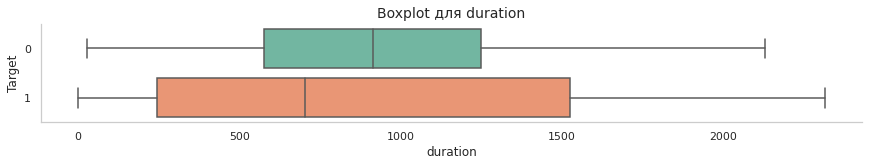

In [ ]:
for column in num_features:
    g = sns.catplot(y='target', x=column, kind="box", data=data, orient='h', height=2, aspect=6, palette="Set2")
    g.fig.set_figwidth(12)
    g.fig.set_figheight(2)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Target', fontsize=12)
    plt.title(f'Boxplot для {column}', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

- Среди тех, кто ушел - имели больше как ежемесячные, так и суммарные платежи, чем те,кто остался.
- Их продолжительность пользования услугами была меньше(скорее всего, они имели краткосрочный контракт).



***КАРТА КОРРЕЛЯЦИИ***

In [ ]:
data_matrix = data.copy()
data_matrix

type paperless_billing             payment_method  \
customer_id                                                                
7590-VHVEG   Month-to-month               Yes           Electronic check   
5575-GNVDE         One year                No               Mailed check   
3668-QPYBK   Month-to-month               Yes               Mailed check   
7795-CFOCW         One year                No  Bank transfer (automatic)   
9237-HQITU   Month-to-month               Yes           Electronic check   
...                     ...               ...                        ...   
6840-RESVB         One year               Yes               Mailed check   
2234-XADUH         One year               Yes    Credit card (automatic)   
4801-JZAZL   Month-to-month               Yes           Electronic check   
8361-LTMKD   Month-to-month               Yes               Mailed check   
3186-AJIEK         Two year               Yes  Bank transfer (automatic)   

             monthly_charges  total_charges internet_service online_security  \
customer_id                                                                    
7590-VHVEG             29.85          31.04              DSL              No   
5575-GNVDE             56.95        2071.84              DSL             Yes   
3668-QPYBK             53.85         226.17              DSL             Yes   
7795-CFOCW             42.30        1960.60              DSL             Yes   
9237-HQITU             70.70         353.50      Fiber optic              No   
...                      ...            ...              ...             ...   
6840-RESVB             84.80        2035.20              DSL             Yes   
2234-XADUH            103.20        7430.40      Fiber optic              No   
4801-JZAZL             29.60         325.60              DSL             Yes   
8361-LTMKD             74.40         520.80      Fiber optic              No   
3186-AJIEK            105.65        7251.82      Fiber optic             Yes   

            online_backup device_protection tech_support streaming_tv  \
customer_id                                                             
7590-VHVEG            Yes                No           No           No   
5575-GNVDE             No               Yes           No           No   
3668-QPYBK            Yes                No           No           No   
7795-CFOCW             No               Yes          Yes           No   
9237-HQITU             No                No           No           No   
...                   ...               ...          ...          ...   
6840-RESVB             No               Yes          Yes          Yes   
2234-XADUH            Yes               Yes           No          Yes   
4801-JZAZL             No                No           No           No   
8361-LTMKD             No                No           No           No   
3186-AJIEK             No               Yes          Yes          Yes   

            streaming_movies  gender senior_citizen partner dependents  \
customer_id                                                              
7590-VHVEG                No  Female             No     Yes         No   
5575-GNVDE                No    Male             No      No         No   
3668-QPYBK                No    Male             No      No         No   
7795-CFOCW                No    Male             No      No         No   
9237-HQITU                No  Female             No      No         No   
...                      ...     ...            ...     ...        ...   
6840-RESVB               Yes    Male             No     Yes        Yes   
2234-XADUH               Yes  Female             No     Yes        Yes   
4801-JZAZL                No  Female             No     Yes        Yes   
8361-LTMKD                No    Male            Yes     Yes         No   
3186-AJIEK               Yes    Male             No      No         No   

            multiple_lines  target  duration  
customer_id                      

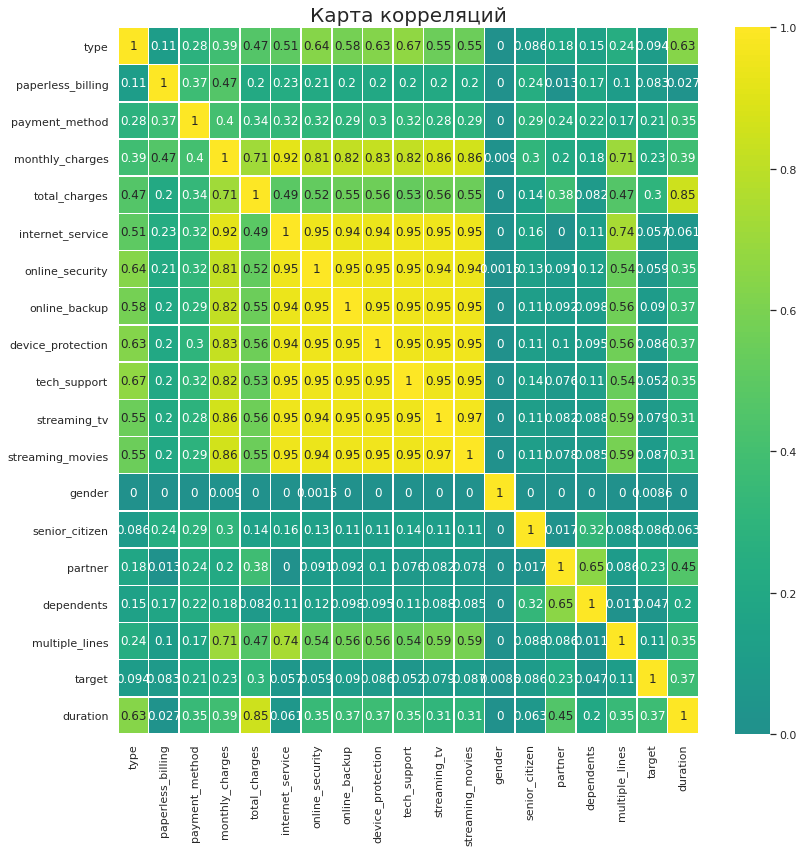

In [ ]:
corr_matrix = data_matrix.phik_matrix(interval_cols=['monthly_charges', 'duration','total_charges','target'])
fig, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', linewidths=0.5, ax=ax, center=0)
ax.set_title('Карта корреляций', fontsize=20)
plt.show()

По карте корреляции видно, что monthly_charges сильно коррелирует с total_charges, duration, multiple_lines, internet_service и другими столбцами с доп.услугами интернета. Также между собой сильно коррелируют multiple_lines и internet_services. С таргетом никто особо не коррелирует.


Для решения этой проблемы создадим новый признак - active_internet. Он показывает, насколько активно человек пользуется интернетом: 'very active' - у него есть хотя бы один подключенный доп сервис, 'active' - у него нет ни одного доп.сервиса, 'no user' - у него вообще нет интернета. Теперь удалим мультиколлинеарные столбцы.


In [ ]:
def active_internet_user(row):
    if (row == 'Yes').any():
        return 'very active'
    elif (row == 'No').all():
        return 'active'
    elif (row == 'No internet').any():
        return 'no user'
    else:
        print('Error')

cols = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
data['active_internet'] = data[cols].apply(active_internet_user, axis=1)

cols_to_drop = cols + ['internet_service', 'monthly_charges']
data = data.drop(cols_to_drop, axis=1)
data

type paperless_billing             payment_method  \
customer_id                                                                
7590-VHVEG   Month-to-month               Yes           Electronic check   
5575-GNVDE         One year                No               Mailed check   
3668-QPYBK   Month-to-month               Yes               Mailed check   
7795-CFOCW         One year                No  Bank transfer (automatic)   
9237-HQITU   Month-to-month               Yes           Electronic check   
...                     ...               ...                        ...   
6840-RESVB         One year               Yes               Mailed check   
2234-XADUH         One year               Yes    Credit card (automatic)   
4801-JZAZL   Month-to-month               Yes           Electronic check   
8361-LTMKD   Month-to-month               Yes               Mailed check   
3186-AJIEK         Two year               Yes  Bank transfer (automatic)   

             total_charges  gender senior_citizen partner dependents  \
customer_id                                                            
7590-VHVEG           31.04  Female             No     Yes         No   
5575-GNVDE         2071.84    Male             No      No         No   
3668-QPYBK          226.17    Male             No      No         No   
7795-CFOCW         1960.60    Male             No      No         No   
9237-HQITU          353.50  Female             No      No         No   
...                    ...     ...            ...     ...        ...   
6840-RESVB         2035.20    Male             No     Yes        Yes   
2234-XADUH         7430.40  Female             No     Yes        Yes   
4801-JZAZL          325.60  Female             No     Yes        Yes   
8361-LTMKD          520.80    Male            Yes     Yes         No   
3186-AJIEK         7251.82    Male             No      No         No   

            multiple_lines  target  duration active_internet  
customer_id                                                   
7590-VHVEG        No phone       1        31     very active  
5575-GNVDE              No       1      1036     very active  
3668-QPYBK              No       1       123     very active  
7795-CFOCW        No phone       1      1371     very active  
9237-HQITU              No       1       153          active  
...                    ...     ...       ...             ...  
6840-RESVB             Yes       1       730     very active  
2234-XADUH             Yes       1      2191     very active  
4801-JZAZL        No phone       1       337     very active  
8361-LTMKD             Yes       1       215          active  
3186-AJIEK              No       1      2010     very active  

[7043 rows x 12 columns]

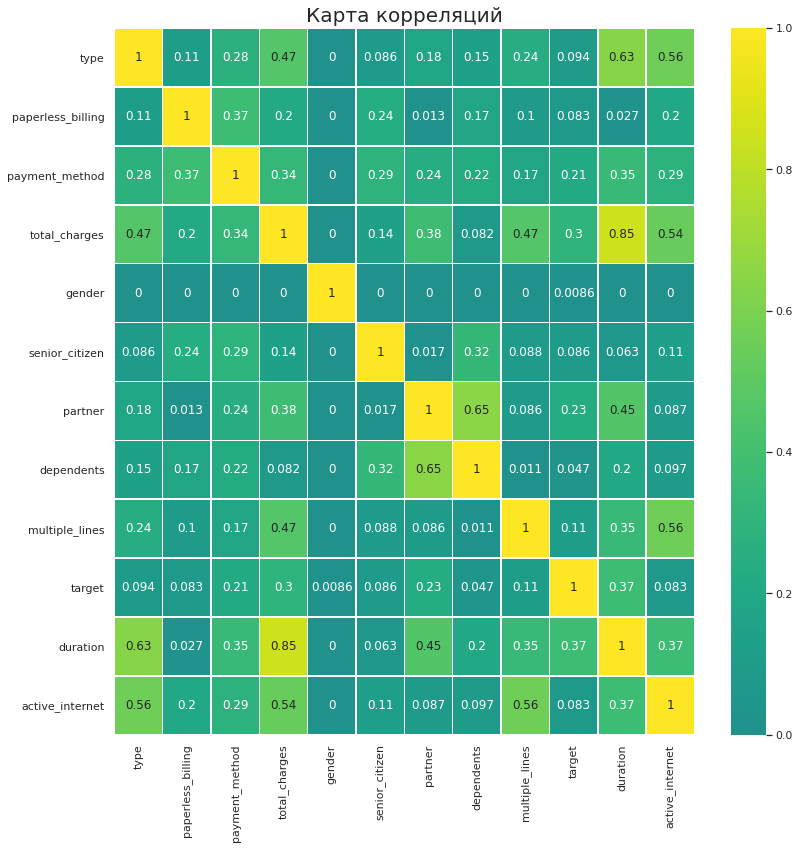

In [ ]:
data_matrix = data.copy()
corr_matrix = data_matrix.phik_matrix(interval_cols=['duration','total_charges','target'])
fig, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', linewidths=0.5, ax=ax, center=0)
ax.set_title('Карта корреляций', fontsize=20)
plt.show()

Снова построили карту корреляции - столбец total_charges все еще сильно коррелирует с duration. Удалим его.

In [ ]:
data = data.drop(['total_charges'],axis = 1)
data

type paperless_billing             payment_method  \
customer_id                                                                
7590-VHVEG   Month-to-month               Yes           Electronic check   
5575-GNVDE         One year                No               Mailed check   
3668-QPYBK   Month-to-month               Yes               Mailed check   
7795-CFOCW         One year                No  Bank transfer (automatic)   
9237-HQITU   Month-to-month               Yes           Electronic check   
...                     ...               ...                        ...   
6840-RESVB         One year               Yes               Mailed check   
2234-XADUH         One year               Yes    Credit card (automatic)   
4801-JZAZL   Month-to-month               Yes           Electronic check   
8361-LTMKD   Month-to-month               Yes               Mailed check   
3186-AJIEK         Two year               Yes  Bank transfer (automatic)   

             gender senior_citizen partner dependents multiple_lines  target  \
customer_id                                                                    
7590-VHVEG   Female             No     Yes         No       No phone       1   
5575-GNVDE     Male             No      No         No             No       1   
3668-QPYBK     Male             No      No         No             No       1   
7795-CFOCW     Male             No      No         No       No phone       1   
9237-HQITU   Female             No      No         No             No       1   
...             ...            ...     ...        ...            ...     ...   
6840-RESVB     Male             No     Yes        Yes            Yes       1   
2234-XADUH   Female             No     Yes        Yes            Yes       1   
4801-JZAZL   Female             No     Yes        Yes       No phone       1   
8361-LTMKD     Male            Yes     Yes         No            Yes       1   
3186-AJIEK     Male             No      No         No             No       1   

             duration active_internet  
customer_id                            
7590-VHVEG         31     very active  
5575-GNVDE       1036     very active  
3668-QPYBK        123     very active  
7795-CFOCW       1371     very active  
9237-HQITU        153          active  
...               ...             ...  
6840-RESVB        730     very active  
2234-XADUH       2191     very active  
4801-JZAZL        337     very active  
8361-LTMKD        215          active  
3186-AJIEK       2010     very active  

[7043 rows x 11 columns]

Переходим к подготовке данных для обучения модели.

***ОБУЧЕНИЕ МОДЕЛИ***

Разделим выборку в соотношении 75:25 на features и target.

In [ ]:
features_train, test_features, target_train, test_target = train_test_split(data.drop('target', axis = 1),
                                          data['target'],
                                          test_size = 0.25,
                                          random_state = SEED,
                                          stratify = data['target'])
features_train.shape, test_features.shape, target_train.shape, test_target.shape


((5282, 10), (1761, 10), (5282,), (1761,))

Закодируем категориальные признаки с помощью get_dummies и масштабируем количественные.

In [ ]:
cat_features = data.drop(['duration','target'], axis=1).columns.tolist()

In [ ]:
features_train = features_train.join(pd.get_dummies(features_train[cat_features], drop_first=True))
features_train.head(5)

type paperless_billing             payment_method  \
customer_id                                                                
1131-QQZEB         Two year                No  Bank transfer (automatic)   
7964-VEXDG   Month-to-month                No           Electronic check   
7310-EGVHZ   Month-to-month                No  Bank transfer (automatic)   
4915-BFSXL         Two year                No    Credit card (automatic)   
8644-XYTSV   Month-to-month               Yes  Bank transfer (automatic)   

            gender senior_citizen partner dependents multiple_lines  duration  \
customer_id                                                                     
1131-QQZEB    Male            Yes     Yes         No            Yes      2163   
7964-VEXDG    Male             No      No        Yes            Yes       641   
7310-EGVHZ    Male             No      No         No             No        31   
4915-BFSXL    Male             No     Yes        Yes            Yes       822   
8644-XYTSV    Male             No     Yes         No       No phone      1279   

            active_internet  ...  payment_method_Electronic check  \
customer_id                  ...                                    
1131-QQZEB          no user  ...                                0   
7964-VEXDG      very active  ...                                1   
7310-EGVHZ          no user  ...                                0   
4915-BFSXL      very active  ...                                0   
8644-XYTSV      very active  ...                                0   

             payment_method_Mailed check  gender_Male  senior_citizen_Yes  \
customer_id                                                                 
1131-QQZEB                             0            1                   1   
7964-VEXDG                             0            1                   0   
7310-EGVHZ                             0            1                   0   
4915-BFSXL                             0            1                   0   
8644-XYTSV                             0            1                   0   

             partner_Yes  dependents_Yes  multiple_lines_No phone  \
customer_id                                                         
1131-QQZEB             1               0                        0   
7964-VEXDG             0               1                        0   
7310-EGVHZ             0               0                        0   
4915-BFSXL             1               1                        0   
8644-XYTSV             1               0                        1   

             multiple_lines_Yes  active_internet_no user  \
customer_id                                                
1131-QQZEB                    1                        1   
7964-VEXDG                    1                        0   
7310-EGVHZ                    0                        1   
4915-BFSXL                    1                        0   
8644-XYTSV                    0                        0   

             active_internet_very active  
customer_id                               
1131-QQZEB                             0  
7964-VEXDG                             1  
7310-EGVHZ                             0  
4915-BFSXL                             1  
8644-XYTSV                             1  

[5 rows x 24 columns]

In [ ]:
test_features = test_features.join(pd.get_dummies(test_features[cat_features], drop_first=True))
test_features.head(5)

type paperless_billing           payment_method  \
customer_id                                                              
9039-ZVJDC   Month-to-month               Yes             Mailed check   
3351-NQLDI         One year               Yes  Credit card (automatic)   
5628-FCGYG   Month-to-month               Yes         Electronic check   
6266-QHOJZ         One year               Yes         Electronic check   
4851-BQDNX         One year               Yes         Electronic check   

             gender senior_citizen partner dependents multiple_lines  \
customer_id                                                            
9039-ZVJDC     Male             No      No         No             No   
3351-NQLDI   Female             No     Yes        Yes            Yes   
5628-FCGYG     Male             No      No         No            Yes   
6266-QHOJZ   Female             No      No         No            Yes   
4851-BQDNX     Male             No     Yes        Yes             No   

             duration active_internet  ...  payment_method_Electronic check  \
customer_id                            ...                                    
9039-ZVJDC         92         no user  ...                                0   
3351-NQLDI        579     very active  ...                                0   
5628-FCGYG        641     very active  ...                                1   
6266-QHOJZ       1979     very active  ...                                1   
4851-BQDNX       1218     very active  ...                                1   

             payment_method_Mailed check  gender_Male  senior_citizen_Yes  \
customer_id                                                                 
9039-ZVJDC                             1            1                   0   
3351-NQLDI                             0            0                   0   
5628-FCGYG                             0            1                   0   
6266-QHOJZ                             0            0                   0   
4851-BQDNX                             0            1                   0   

             partner_Yes  dependents_Yes  multiple_lines_No phone  \
customer_id                                                         
9039-ZVJDC             0               0                        0   
3351-NQLDI             1               1                        0   
5628-FCGYG             0               0                        0   
6266-QHOJZ             0               0                        0   
4851-BQDNX             1               1                        0   

             multiple_lines_Yes  active_internet_no user  \
customer_id                                                
9039-ZVJDC                    0                        1   
3351-NQLDI                    1                        0   
5628-FCGYG                    1                        0   
6266-QHOJZ                    1                        0   
4851-BQDNX                    0                        0   

             active_internet_very active  
customer_id                               
9039-ZVJDC                             0  
3351-NQLDI                             1  
5628-FCGYG                             1  
6266-QHOJZ                             1  
4851-BQDNX                             1  

[5 rows x 24 columns]

In [ ]:
features_train.drop(cat_features, axis = 1, inplace = True)
test_features.drop(cat_features, axis = 1, inplace = True)

In [ ]:
features_train.columns == test_features.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

Будем обучать три модели - Logistic Regression, Random Forest и CatBoost. Подбирать параметры будем при помощи GridSearch.

In [ ]:
parameters = {'lr__fit_intercept' : [True,False],
               'lr__penalty' : ['l1', 'l2'],
               'lr__solver' :['saga','liblinear', 'lbfgs'],
               'lr__C' : [0.01, 0.1, 1]
              }

steps = [('standard_scaler', StandardScaler()),
         ('lr', LogisticRegression(random_state = SEED, class_weight = 'balanced'))
        ]
pipe = Pipeline(steps)
lr = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)
lr.fit(features_train, target_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=251223))]),
             param_grid={'lr__C': [0.01, 0.1, 1],
                         'lr__fit_intercept': [True, False],
                         'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['saga', 'liblinear', 'lbfgs']},
             scoring='roc_auc')

In [ ]:
result = pd.DataFrame(columns=['name_model',
                          'best_roc_auc',
                         ],
                 data=[['Logistic_Regression',
                        lr.best_score_,
                        ]]
                )
result

name_model  best_roc_auc
0  Logistic_Regression      0.749793

In [ ]:
parameters = {
    'rfc__n_estimators' : [25,50,100,150],
    'rfc__criterion' : ['gini', 'entropy'],
    'rfc__max_depth':[5,10,20]
}
steps = [
         ('rfc', RandomForestClassifier(random_state=SEED, class_weight = 'balanced', n_jobs = -1))
        ]
pipe = Pipeline(steps)
rfc = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)
rfc.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rfc',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=251223))]),
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_depth': [5, 10, 20],
                         'rfc__n_estimators': [25, 50, 100, 150]},
             scoring='roc_auc')

In [ ]:
result.loc[result.shape[0]]=['Random_Forest',
                        rfc.best_score_,
                      ]
result

name_model  best_roc_auc
0  Logistic_Regression      0.749793
1        Random_Forest      0.812878

In [ ]:
parameters = {'cbc__depth':[3,1,2,6,4,5,7,8,9,10],
          'cbc__iterations':[250,100],
          'cbc__learning_rate':[0.001,0.01,0.1],
          'cbc__loss_function': ['Logloss', 'CrossEntropy']
          }
steps = [
    ('cbc', CatBoostClassifier(random_state=SEED, auto_class_weights='Balanced'))
]
pipe = Pipeline(steps)

cbc = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)

cbc.fit(features_train, target_train)

0:	learn: 0.6929451	total: 48ms	remaining: 11.9s
1:	learn: 0.6927172	total: 48.9ms	remaining: 6.06s
2:	learn: 0.6925001	total: 49.7ms	remaining: 4.09s
3:	learn: 0.6922817	total: 50.6ms	remaining: 3.11s
4:	learn: 0.6920666	total: 51.4ms	remaining: 2.52s
5:	learn: 0.6918364	total: 52.1ms	remaining: 2.12s
6:	learn: 0.6916110	total: 52.8ms	remaining: 1.83s
7:	learn: 0.6914001	total: 53.7ms	remaining: 1.62s
8:	learn: 0.6911777	total: 54.6ms	remaining: 1.46s
9:	learn: 0.6909645	total: 55.4ms	remaining: 1.33s
10:	learn: 0.6907777	total: 56.3ms	remaining: 1.22s
11:	learn: 0.6905512	total: 57.1ms	remaining: 1.13s
12:	learn: 0.6903306	total: 57.9ms	remaining: 1.05s
13:	learn: 0.6901121	total: 58.6ms	remaining: 988ms
14:	learn: 0.6898893	total: 59.3ms	remaining: 929ms
15:	learn: 0.6897051	total: 60.1ms	remaining: 879ms
16:	learn: 0.6894633	total: 61.2ms	remaining: 838ms
17:	learn: 0.6892229	total: 62.3ms	remaining: 802ms
18:	learn: 0.6889780	total: 63.4ms	remaining: 770ms
19:	learn: 0.6887765	tot

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6911280	total: 888us	remaining: 221ms
1:	learn: 0.6889170	total: 1.93ms	remaining: 240ms
2:	learn: 0.6865738	total: 2.92ms	remaining: 241ms
3:	learn: 0.6846764	total: 3.73ms	remaining: 229ms
4:	learn: 0.6825742	total: 4.61ms	remaining: 226ms
5:	learn: 0.6810933	total: 5.53ms	remaining: 225ms
6:	learn: 0.6793559	total: 6.44ms	remaining: 223ms
7:	learn: 0.6775712	total: 7.25ms	remaining: 219ms
8:	learn: 0.6755483	total: 8.12ms	remaining: 218ms
9:	learn: 0.6739830	total: 8.95ms	remaining: 215ms
10:	learn: 0.6723597	total: 9.92ms	remaining: 215ms
11:	learn: 0.6705525	total: 10.8ms	remaining: 214ms
12:	learn: 0.6689567	total: 11.7ms	remaining: 213ms
13:	learn: 0.6673868	total: 12.6ms	remaining: 213ms
14:	learn: 0.6655632	total: 13.4ms	remaining: 210ms
15:	learn: 0.6643639	total: 14.3ms	remaining: 209ms
16:	learn: 0.6625258	total: 15.2ms	remaining: 208ms
17:	learn: 0.6606965	total: 16ms	remaining: 206ms
18:	learn: 0.6589380	total: 16.8ms	remaining: 204ms
19:	learn: 0.6577156	tota

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6739729	total: 889us	remaining: 221ms
1:	learn: 0.6581984	total: 1.91ms	remaining: 237ms
2:	learn: 0.6442358	total: 2.83ms	remaining: 233ms
3:	learn: 0.6311175	total: 3.64ms	remaining: 224ms
4:	learn: 0.6235363	total: 4.44ms	remaining: 218ms
5:	learn: 0.6120263	total: 5.26ms	remaining: 214ms
6:	learn: 0.6032517	total: 6.03ms	remaining: 209ms
7:	learn: 0.5952360	total: 6.9ms	remaining: 209ms
8:	learn: 0.5876432	total: 7.68ms	remaining: 206ms
9:	learn: 0.5823052	total: 8.46ms	remaining: 203ms
10:	learn: 0.5774849	total: 9.33ms	remaining: 203ms
11:	learn: 0.5711190	total: 10.2ms	remaining: 202ms
12:	learn: 0.5642784	total: 11ms	remaining: 201ms
13:	learn: 0.5602545	total: 11.9ms	remaining: 200ms
14:	learn: 0.5573099	total: 12.7ms	remaining: 199ms
15:	learn: 0.5530213	total: 13.5ms	remaining: 198ms
16:	learn: 0.5506841	total: 14.4ms	remaining: 197ms
17:	learn: 0.5476795	total: 15.3ms	remaining: 197ms
18:	learn: 0.5447901	total: 16.1ms	remaining: 196ms
19:	learn: 0.5408314	total

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6929691	total: 574us	remaining: 56.9ms
1:	learn: 0.6927781	total: 1.21ms	remaining: 59.3ms
2:	learn: 0.6926129	total: 1.77ms	remaining: 57.4ms
3:	learn: 0.6924186	total: 2.23ms	remaining: 53.6ms
4:	learn: 0.6922547	total: 2.7ms	remaining: 51.3ms
5:	learn: 0.6920714	total: 3.23ms	remaining: 50.7ms
6:	learn: 0.6918968	total: 3.77ms	remaining: 50.1ms
7:	learn: 0.6917269	total: 4.27ms	remaining: 49.1ms
8:	learn: 0.6915480	total: 4.77ms	remaining: 48.3ms
9:	learn: 0.6913564	total: 5.25ms	remaining: 47.2ms
10:	learn: 0.6911832	total: 5.79ms	remaining: 46.8ms
11:	learn: 0.6910078	total: 6.3ms	remaining: 46.2ms
12:	learn: 0.6908434	total: 6.78ms	remaining: 45.4ms
13:	learn: 0.6906568	total: 7.28ms	remaining: 44.7ms
14:	learn: 0.6904752	total: 7.73ms	remaining: 43.8ms
15:	learn: 0.6903100	total: 8.25ms	remaining: 43.3ms
16:	learn: 0.6901509	total: 8.78ms	remaining: 42.8ms
17:	learn: 0.6899764	total: 9.25ms	remaining: 42.1ms
18:	learn: 0.6898026	total: 9.76ms	remaining: 41.6ms
19:	le

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6914140	total: 556us	remaining: 55.1ms
1:	learn: 0.6895200	total: 1.18ms	remaining: 57.7ms
2:	learn: 0.6879045	total: 1.69ms	remaining: 54.8ms
3:	learn: 0.6863545	total: 2.16ms	remaining: 51.8ms
4:	learn: 0.6848080	total: 2.64ms	remaining: 50.1ms
5:	learn: 0.6830698	total: 3.13ms	remaining: 49.1ms
6:	learn: 0.6814541	total: 3.57ms	remaining: 47.4ms
7:	learn: 0.6798937	total: 4.02ms	remaining: 46.2ms
8:	learn: 0.6782780	total: 4.48ms	remaining: 45.3ms
9:	learn: 0.6765241	total: 4.98ms	remaining: 44.8ms
10:	learn: 0.6749980	total: 5.44ms	remaining: 44ms
11:	learn: 0.6734618	total: 5.93ms	remaining: 43.5ms
12:	learn: 0.6720268	total: 6.36ms	remaining: 42.6ms
13:	learn: 0.6704447	total: 6.78ms	remaining: 41.7ms
14:	learn: 0.6688924	total: 7.22ms	remaining: 40.9ms
15:	learn: 0.6675054	total: 7.66ms	remaining: 40.2ms
16:	learn: 0.6662935	total: 8.12ms	remaining: 39.6ms
17:	learn: 0.6648801	total: 8.6ms	remaining: 39.2ms
18:	learn: 0.6634599	total: 9.05ms	remaining: 38.6ms
19:	lea

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6765294	total: 592us	remaining: 58.7ms
1:	learn: 0.6598990	total: 1.18ms	remaining: 57.7ms
2:	learn: 0.6474193	total: 1.66ms	remaining: 53.6ms
3:	learn: 0.6393623	total: 2.11ms	remaining: 50.7ms
4:	learn: 0.6317657	total: 2.6ms	remaining: 49.5ms
5:	learn: 0.6220093	total: 3.06ms	remaining: 48ms
6:	learn: 0.6144270	total: 3.56ms	remaining: 47.3ms
7:	learn: 0.6054933	total: 4.07ms	remaining: 46.8ms
8:	learn: 0.5981762	total: 4.56ms	remaining: 46.1ms
9:	learn: 0.5910848	total: 5.11ms	remaining: 46ms
10:	learn: 0.5864057	total: 5.6ms	remaining: 45.3ms
11:	learn: 0.5814807	total: 6.11ms	remaining: 44.8ms
12:	learn: 0.5761662	total: 6.6ms	remaining: 44.2ms
13:	learn: 0.5720323	total: 7.15ms	remaining: 43.9ms
14:	learn: 0.5690133	total: 7.63ms	remaining: 43.2ms
15:	learn: 0.5657064	total: 8.13ms	remaining: 42.7ms
16:	learn: 0.5624060	total: 8.64ms	remaining: 42.2ms
17:	learn: 0.5600750	total: 9.11ms	remaining: 41.5ms
18:	learn: 0.5571356	total: 9.56ms	remaining: 40.8ms
19:	learn: 

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6930768	total: 766us	remaining: 191ms
1:	learn: 0.6929896	total: 1.61ms	remaining: 199ms
2:	learn: 0.6929268	total: 2.27ms	remaining: 187ms
3:	learn: 0.6928876	total: 2.87ms	remaining: 177ms
4:	learn: 0.6928136	total: 3.62ms	remaining: 177ms
5:	learn: 0.6927612	total: 4.23ms	remaining: 172ms
6:	learn: 0.6926736	total: 4.86ms	remaining: 169ms
7:	learn: 0.6926246	total: 5.47ms	remaining: 165ms
8:	learn: 0.6925765	total: 6.08ms	remaining: 163ms
9:	learn: 0.6924964	total: 6.82ms	remaining: 164ms
10:	learn: 0.6924094	total: 7.53ms	remaining: 164ms
11:	learn: 0.6923327	total: 8.23ms	remaining: 163ms
12:	learn: 0.6922994	total: 8.97ms	remaining: 164ms
13:	learn: 0.6922122	total: 9.56ms	remaining: 161ms
14:	learn: 0.6921321	total: 10.3ms	remaining: 161ms
15:	learn: 0.6920855	total: 10.8ms	remaining: 158ms
16:	learn: 0.6920156	total: 11.5ms	remaining: 157ms
17:	learn: 0.6919615	total: 12ms	remaining: 155ms
18:	learn: 0.6918962	total: 12.7ms	remaining: 154ms
19:	learn: 0.6918473	tota

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6924279	total: 691us	remaining: 172ms
1:	learn: 0.6916384	total: 1.43ms	remaining: 177ms
2:	learn: 0.6911252	total: 2ms	remaining: 164ms
3:	learn: 0.6908025	total: 2.54ms	remaining: 156ms
4:	learn: 0.6902768	total: 3.17ms	remaining: 155ms
5:	learn: 0.6897856	total: 3.68ms	remaining: 150ms
6:	learn: 0.6889440	total: 4.32ms	remaining: 150ms
7:	learn: 0.6884662	total: 4.87ms	remaining: 147ms
8:	learn: 0.6879832	total: 5.49ms	remaining: 147ms
9:	learn: 0.6875146	total: 6.09ms	remaining: 146ms
10:	learn: 0.6867871	total: 6.7ms	remaining: 146ms
11:	learn: 0.6863101	total: 7.28ms	remaining: 144ms
12:	learn: 0.6856623	total: 7.88ms	remaining: 144ms
13:	learn: 0.6852019	total: 8.48ms	remaining: 143ms
14:	learn: 0.6844516	total: 9.07ms	remaining: 142ms
15:	learn: 0.6838922	total: 9.7ms	remaining: 142ms
16:	learn: 0.6832034	total: 10.4ms	remaining: 142ms
17:	learn: 0.6826581	total: 11ms	remaining: 142ms
18:	learn: 0.6820995	total: 11.6ms	remaining: 141ms
19:	learn: 0.6813286	total: 12

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6864100	total: 761us	remaining: 190ms
1:	learn: 0.6809173	total: 1.5ms	remaining: 186ms
2:	learn: 0.6755605	total: 2.18ms	remaining: 179ms
3:	learn: 0.6726816	total: 2.79ms	remaining: 172ms
4:	learn: 0.6652033	total: 3.81ms	remaining: 186ms
5:	learn: 0.6606683	total: 4.57ms	remaining: 186ms
6:	learn: 0.6551772	total: 5.37ms	remaining: 187ms
7:	learn: 0.6513822	total: 6.16ms	remaining: 186ms
8:	learn: 0.6475982	total: 6.95ms	remaining: 186ms
9:	learn: 0.6445062	total: 7.76ms	remaining: 186ms
10:	learn: 0.6416652	total: 8.49ms	remaining: 184ms
11:	learn: 0.6387759	total: 9.29ms	remaining: 184ms
12:	learn: 0.6367952	total: 10.1ms	remaining: 184ms
13:	learn: 0.6345218	total: 10.8ms	remaining: 182ms
14:	learn: 0.6313580	total: 11.5ms	remaining: 181ms
15:	learn: 0.6263377	total: 12.6ms	remaining: 184ms
16:	learn: 0.6227365	total: 13.4ms	remaining: 184ms
17:	learn: 0.6196069	total: 14.3ms	remaining: 184ms
18:	learn: 0.6175491	total: 15.1ms	remaining: 184ms
19:	learn: 0.6152357	tot

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6930894	total: 459us	remaining: 45.5ms
1:	learn: 0.6930293	total: 921us	remaining: 45.2ms
2:	learn: 0.6930012	total: 1.31ms	remaining: 42.3ms
3:	learn: 0.6929466	total: 1.61ms	remaining: 38.7ms
4:	learn: 0.6928975	total: 1.91ms	remaining: 36.2ms
5:	learn: 0.6928471	total: 2.21ms	remaining: 34.6ms
6:	learn: 0.6927908	total: 2.51ms	remaining: 33.4ms
7:	learn: 0.6927404	total: 2.85ms	remaining: 32.8ms
8:	learn: 0.6926816	total: 3.2ms	remaining: 32.3ms
9:	learn: 0.6926508	total: 3.51ms	remaining: 31.6ms
10:	learn: 0.6925943	total: 3.85ms	remaining: 31.2ms
11:	learn: 0.6925343	total: 4.2ms	remaining: 30.8ms
12:	learn: 0.6924698	total: 4.52ms	remaining: 30.2ms
13:	learn: 0.6924122	total: 4.88ms	remaining: 30ms
14:	learn: 0.6923809	total: 5.21ms	remaining: 29.5ms
15:	learn: 0.6923354	total: 5.54ms	remaining: 29.1ms
16:	learn: 0.6922691	total: 5.9ms	remaining: 28.8ms
17:	learn: 0.6922201	total: 6.23ms	remaining: 28.4ms
18:	learn: 0.6921585	total: 6.56ms	remaining: 28ms
19:	learn: 0

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6925610	total: 443us	remaining: 43.9ms
1:	learn: 0.6919766	total: 948us	remaining: 46.5ms
2:	learn: 0.6916709	total: 1.33ms	remaining: 43.1ms
3:	learn: 0.6911842	total: 1.66ms	remaining: 39.9ms
4:	learn: 0.6906873	total: 1.99ms	remaining: 37.7ms
5:	learn: 0.6902246	total: 2.32ms	remaining: 36.3ms
6:	learn: 0.6896282	total: 2.78ms	remaining: 37ms
7:	learn: 0.6891485	total: 3.17ms	remaining: 36.5ms
8:	learn: 0.6885780	total: 3.61ms	remaining: 36.5ms
9:	learn: 0.6882810	total: 4.09ms	remaining: 36.8ms
10:	learn: 0.6877216	total: 4.55ms	remaining: 36.8ms
11:	learn: 0.6871538	total: 5.03ms	remaining: 36.9ms
12:	learn: 0.6865492	total: 5.55ms	remaining: 37.2ms
13:	learn: 0.6860058	total: 6.01ms	remaining: 36.9ms
14:	learn: 0.6857185	total: 6.4ms	remaining: 36.3ms
15:	learn: 0.6852494	total: 6.8ms	remaining: 35.7ms
16:	learn: 0.6846672	total: 7.28ms	remaining: 35.5ms
17:	learn: 0.6842071	total: 7.74ms	remaining: 35.3ms
18:	learn: 0.6836474	total: 8.2ms	remaining: 34.9ms
19:	learn:

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6875691	total: 557us	remaining: 55.2ms
1:	learn: 0.6827183	total: 1.18ms	remaining: 57.6ms
2:	learn: 0.6796817	total: 1.65ms	remaining: 53.3ms
3:	learn: 0.6746334	total: 2.06ms	remaining: 49.5ms
4:	learn: 0.6700585	total: 2.44ms	remaining: 46.4ms
5:	learn: 0.6661662	total: 2.87ms	remaining: 44.9ms
6:	learn: 0.6619356	total: 3.35ms	remaining: 44.4ms
7:	learn: 0.6585500	total: 3.74ms	remaining: 43.1ms
8:	learn: 0.6556565	total: 4.21ms	remaining: 42.6ms
9:	learn: 0.6512079	total: 4.65ms	remaining: 41.9ms
10:	learn: 0.6475394	total: 5.1ms	remaining: 41.3ms
11:	learn: 0.6436373	total: 5.54ms	remaining: 40.6ms
12:	learn: 0.6400401	total: 5.97ms	remaining: 40ms
13:	learn: 0.6370738	total: 6.41ms	remaining: 39.4ms
14:	learn: 0.6354464	total: 6.86ms	remaining: 38.9ms
15:	learn: 0.6328633	total: 7.25ms	remaining: 38.1ms
16:	learn: 0.6305358	total: 7.74ms	remaining: 37.8ms
17:	learn: 0.6293138	total: 8.18ms	remaining: 37.3ms
18:	learn: 0.6260985	total: 8.67ms	remaining: 37ms
19:	learn

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6929864	total: 789us	remaining: 197ms
1:	learn: 0.6928996	total: 1.65ms	remaining: 204ms
2:	learn: 0.6927271	total: 2.54ms	remaining: 210ms
3:	learn: 0.6925953	total: 3.31ms	remaining: 204ms
4:	learn: 0.6924354	total: 4.17ms	remaining: 204ms
5:	learn: 0.6922609	total: 5.01ms	remaining: 204ms
6:	learn: 0.6921012	total: 5.83ms	remaining: 202ms
7:	learn: 0.6919217	total: 6.64ms	remaining: 201ms
8:	learn: 0.6917629	total: 7.46ms	remaining: 200ms
9:	learn: 0.6915927	total: 8.31ms	remaining: 200ms
10:	learn: 0.6914215	total: 9.15ms	remaining: 199ms
11:	learn: 0.6912645	total: 9.99ms	remaining: 198ms
12:	learn: 0.6910968	total: 10.7ms	remaining: 195ms
13:	learn: 0.6909384	total: 11.5ms	remaining: 194ms
14:	learn: 0.6907995	total: 12.3ms	remaining: 193ms
15:	learn: 0.6906318	total: 13.1ms	remaining: 192ms
16:	learn: 0.6904748	total: 14ms	remaining: 192ms
17:	learn: 0.6903030	total: 14.9ms	remaining: 192ms
18:	learn: 0.6901495	total: 15.7ms	remaining: 191ms
19:	learn: 0.6899847	tota

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6915342	total: 773us	remaining: 193ms
1:	learn: 0.6907055	total: 1.71ms	remaining: 213ms
2:	learn: 0.6892412	total: 2.52ms	remaining: 208ms
3:	learn: 0.6876624	total: 3.23ms	remaining: 199ms
4:	learn: 0.6862488	total: 4.02ms	remaining: 197ms
5:	learn: 0.6848396	total: 4.77ms	remaining: 194ms
6:	learn: 0.6833524	total: 5.48ms	remaining: 190ms
7:	learn: 0.6817477	total: 6.17ms	remaining: 187ms
8:	learn: 0.6803584	total: 6.92ms	remaining: 185ms
9:	learn: 0.6795970	total: 7.71ms	remaining: 185ms
10:	learn: 0.6780773	total: 8.51ms	remaining: 185ms
11:	learn: 0.6766047	total: 9.29ms	remaining: 184ms
12:	learn: 0.6752025	total: 9.97ms	remaining: 182ms
13:	learn: 0.6738647	total: 10.7ms	remaining: 180ms
14:	learn: 0.6725380	total: 11.4ms	remaining: 179ms
15:	learn: 0.6712670	total: 12.2ms	remaining: 178ms
16:	learn: 0.6699737	total: 12.9ms	remaining: 177ms
17:	learn: 0.6690997	total: 13.6ms	remaining: 175ms
18:	learn: 0.6679686	total: 14.4ms	remaining: 175ms
19:	learn: 0.6667893	to

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6777803	total: 867us	remaining: 216ms
1:	learn: 0.6701777	total: 1.63ms	remaining: 202ms
2:	learn: 0.6584611	total: 2.34ms	remaining: 193ms
3:	learn: 0.6467394	total: 3.09ms	remaining: 190ms
4:	learn: 0.6378909	total: 3.96ms	remaining: 194ms
5:	learn: 0.6333158	total: 4.73ms	remaining: 193ms
6:	learn: 0.6247247	total: 5.52ms	remaining: 192ms
7:	learn: 0.6176588	total: 6.32ms	remaining: 191ms
8:	learn: 0.6117773	total: 7.07ms	remaining: 189ms
9:	learn: 0.6068304	total: 7.83ms	remaining: 188ms
10:	learn: 0.6000822	total: 8.63ms	remaining: 187ms
11:	learn: 0.5950666	total: 9.37ms	remaining: 186ms
12:	learn: 0.5913804	total: 10.1ms	remaining: 183ms
13:	learn: 0.5876373	total: 10.8ms	remaining: 182ms
14:	learn: 0.5846389	total: 11.5ms	remaining: 179ms
15:	learn: 0.5808913	total: 12.2ms	remaining: 179ms
16:	learn: 0.5788148	total: 13ms	remaining: 179ms
17:	learn: 0.5765617	total: 13.8ms	remaining: 177ms
18:	learn: 0.5734014	total: 14.5ms	remaining: 177ms
19:	learn: 0.5711065	tota

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6929985	total: 547us	remaining: 54.2ms
1:	learn: 0.6928737	total: 1.21ms	remaining: 59.4ms
2:	learn: 0.6927194	total: 1.72ms	remaining: 55.6ms
3:	learn: 0.6925701	total: 2.13ms	remaining: 51.1ms
4:	learn: 0.6924607	total: 2.53ms	remaining: 48ms
5:	learn: 0.6923345	total: 2.97ms	remaining: 46.6ms
6:	learn: 0.6922060	total: 3.35ms	remaining: 44.5ms
7:	learn: 0.6920748	total: 3.72ms	remaining: 42.8ms
8:	learn: 0.6919522	total: 4.07ms	remaining: 41.2ms
9:	learn: 0.6918257	total: 4.49ms	remaining: 40.4ms
10:	learn: 0.6916781	total: 4.91ms	remaining: 39.7ms
11:	learn: 0.6915650	total: 5.42ms	remaining: 39.8ms
12:	learn: 0.6914406	total: 5.92ms	remaining: 39.7ms
13:	learn: 0.6912926	total: 6.42ms	remaining: 39.5ms
14:	learn: 0.6912205	total: 6.9ms	remaining: 39.1ms
15:	learn: 0.6910848	total: 7.36ms	remaining: 38.6ms
16:	learn: 0.6909715	total: 7.75ms	remaining: 37.9ms
17:	learn: 0.6908449	total: 8.17ms	remaining: 37.2ms
18:	learn: 0.6907356	total: 8.53ms	remaining: 36.4ms
19:	lea

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6917040	total: 557us	remaining: 55.1ms
1:	learn: 0.6904127	total: 1.08ms	remaining: 53ms
2:	learn: 0.6889497	total: 1.64ms	remaining: 53.1ms
3:	learn: 0.6875452	total: 2.19ms	remaining: 52.7ms
4:	learn: 0.6864996	total: 2.71ms	remaining: 51.4ms
5:	learn: 0.6852778	total: 3.15ms	remaining: 49.3ms
6:	learn: 0.6840784	total: 3.61ms	remaining: 48ms
7:	learn: 0.6828748	total: 4.03ms	remaining: 46.4ms
8:	learn: 0.6817518	total: 4.5ms	remaining: 45.5ms
9:	learn: 0.6806351	total: 4.94ms	remaining: 44.5ms
10:	learn: 0.6793320	total: 5.48ms	remaining: 44.3ms
11:	learn: 0.6786110	total: 5.92ms	remaining: 43.4ms
12:	learn: 0.6775308	total: 6.32ms	remaining: 42.3ms
13:	learn: 0.6764225	total: 6.68ms	remaining: 41ms
14:	learn: 0.6757336	total: 7.02ms	remaining: 39.8ms
15:	learn: 0.6744617	total: 7.38ms	remaining: 38.8ms
16:	learn: 0.6734819	total: 7.97ms	remaining: 38.9ms
17:	learn: 0.6724817	total: 8.41ms	remaining: 38.3ms
18:	learn: 0.6715404	total: 8.89ms	remaining: 37.9ms
19:	learn: 

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6793441	total: 460us	remaining: 45.6ms
1:	learn: 0.6693183	total: 991us	remaining: 48.6ms
2:	learn: 0.6615152	total: 1.38ms	remaining: 44.5ms
3:	learn: 0.6532135	total: 1.71ms	remaining: 41ms
4:	learn: 0.6461510	total: 2.06ms	remaining: 39.1ms
5:	learn: 0.6373397	total: 2.46ms	remaining: 38.6ms
6:	learn: 0.6323754	total: 2.82ms	remaining: 37.5ms
7:	learn: 0.6250480	total: 3.19ms	remaining: 36.7ms
8:	learn: 0.6190563	total: 3.56ms	remaining: 36ms
9:	learn: 0.6137482	total: 3.95ms	remaining: 35.5ms
10:	learn: 0.6091391	total: 4.33ms	remaining: 35ms
11:	learn: 0.6050608	total: 4.73ms	remaining: 34.7ms
12:	learn: 0.6008650	total: 5.14ms	remaining: 34.4ms
13:	learn: 0.5981854	total: 5.52ms	remaining: 33.9ms
14:	learn: 0.5956624	total: 5.91ms	remaining: 33.5ms
15:	learn: 0.5915473	total: 6.31ms	remaining: 33.1ms
16:	learn: 0.5877950	total: 6.71ms	remaining: 32.8ms
17:	learn: 0.5834478	total: 7.12ms	remaining: 32.4ms
18:	learn: 0.5807707	total: 7.52ms	remaining: 32.1ms
19:	learn: 

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6928733	total: 1.96ms	remaining: 489ms
1:	learn: 0.6925996	total: 3.6ms	remaining: 446ms
2:	learn: 0.6922460	total: 4.96ms	remaining: 409ms
3:	learn: 0.6918611	total: 6.46ms	remaining: 397ms
4:	learn: 0.6915448	total: 8.03ms	remaining: 393ms
5:	learn: 0.6912682	total: 9.26ms	remaining: 376ms
6:	learn: 0.6909274	total: 10.7ms	remaining: 372ms
7:	learn: 0.6905385	total: 12.2ms	remaining: 369ms
8:	learn: 0.6902178	total: 13.9ms	remaining: 371ms
9:	learn: 0.6898193	total: 15.5ms	remaining: 372ms
10:	learn: 0.6894938	total: 17.1ms	remaining: 372ms
11:	learn: 0.6893388	total: 18.1ms	remaining: 360ms
12:	learn: 0.6890356	total: 19.5ms	remaining: 356ms
13:	learn: 0.6887241	total: 21ms	remaining: 354ms
14:	learn: 0.6883520	total: 22.4ms	remaining: 350ms
15:	learn: 0.6879836	total: 24ms	remaining: 351ms
16:	learn: 0.6876397	total: 25.5ms	remaining: 350ms
17:	learn: 0.6872575	total: 27.2ms	remaining: 350ms
18:	learn: 0.6869638	total: 28.8ms	remaining: 350ms
19:	learn: 0.6866334	total:

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6904331	total: 1.54ms	remaining: 383ms
1:	learn: 0.6877536	total: 3.31ms	remaining: 410ms
2:	learn: 0.6843330	total: 4.86ms	remaining: 401ms
3:	learn: 0.6806553	total: 6.39ms	remaining: 393ms
4:	learn: 0.6777073	total: 7.89ms	remaining: 387ms
5:	learn: 0.6751753	total: 9.12ms	remaining: 371ms
6:	learn: 0.6720817	total: 10.9ms	remaining: 379ms
7:	learn: 0.6686058	total: 12.4ms	remaining: 376ms
8:	learn: 0.6658178	total: 13.9ms	remaining: 372ms
9:	learn: 0.6624057	total: 15.4ms	remaining: 370ms
10:	learn: 0.6596651	total: 17ms	remaining: 369ms
11:	learn: 0.6584341	total: 18ms	remaining: 358ms
12:	learn: 0.6559023	total: 19.6ms	remaining: 357ms
13:	learn: 0.6537977	total: 21.1ms	remaining: 356ms
14:	learn: 0.6507695	total: 22.5ms	remaining: 352ms
15:	learn: 0.6486996	total: 24.1ms	remaining: 353ms
16:	learn: 0.6460308	total: 25.5ms	remaining: 350ms
17:	learn: 0.6431094	total: 27.1ms	remaining: 349ms
18:	learn: 0.6411842	total: 28.4ms	remaining: 346ms
19:	learn: 0.6387210	total

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6674822	total: 1.55ms	remaining: 387ms
1:	learn: 0.6453547	total: 3.33ms	remaining: 413ms
2:	learn: 0.6209080	total: 5ms	remaining: 412ms
3:	learn: 0.5988457	total: 6.71ms	remaining: 412ms
4:	learn: 0.5863189	total: 8.19ms	remaining: 401ms
5:	learn: 0.5696845	total: 9.84ms	remaining: 400ms
6:	learn: 0.5576671	total: 11.4ms	remaining: 397ms
7:	learn: 0.5505204	total: 13.1ms	remaining: 398ms
8:	learn: 0.5452104	total: 14.7ms	remaining: 393ms
9:	learn: 0.5394266	total: 16.3ms	remaining: 392ms
10:	learn: 0.5330248	total: 17.8ms	remaining: 386ms
11:	learn: 0.5283296	total: 19.3ms	remaining: 382ms
12:	learn: 0.5217630	total: 20.8ms	remaining: 380ms
13:	learn: 0.5163510	total: 22.8ms	remaining: 385ms
14:	learn: 0.5111115	total: 24.3ms	remaining: 380ms
15:	learn: 0.5072921	total: 25.8ms	remaining: 377ms
16:	learn: 0.5039947	total: 27.8ms	remaining: 381ms
17:	learn: 0.4991090	total: 30ms	remaining: 386ms
18:	learn: 0.4946641	total: 32ms	remaining: 389ms
19:	learn: 0.4920282	total: 3

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6929335	total: 1.33ms	remaining: 131ms
1:	learn: 0.6927075	total: 2.64ms	remaining: 129ms
2:	learn: 0.6924575	total: 3.85ms	remaining: 125ms
3:	learn: 0.6922466	total: 5.12ms	remaining: 123ms
4:	learn: 0.6920581	total: 6.21ms	remaining: 118ms
5:	learn: 0.6918494	total: 7.45ms	remaining: 117ms
6:	learn: 0.6916178	total: 8.64ms	remaining: 115ms
7:	learn: 0.6914124	total: 9.71ms	remaining: 112ms
8:	learn: 0.6911666	total: 10.8ms	remaining: 109ms
9:	learn: 0.6909235	total: 12ms	remaining: 108ms
10:	learn: 0.6906889	total: 13.5ms	remaining: 109ms
11:	learn: 0.6904512	total: 15.1ms	remaining: 110ms
12:	learn: 0.6902400	total: 16.9ms	remaining: 113ms
13:	learn: 0.6900280	total: 18.5ms	remaining: 113ms
14:	learn: 0.6898017	total: 20ms	remaining: 114ms
15:	learn: 0.6895307	total: 21.5ms	remaining: 113ms
16:	learn: 0.6892969	total: 22.7ms	remaining: 111ms
17:	learn: 0.6890893	total: 23.9ms	remaining: 109ms
18:	learn: 0.6888793	total: 25.2ms	remaining: 107ms
19:	learn: 0.6886514	total

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6910586	total: 1.35ms	remaining: 134ms
1:	learn: 0.6888114	total: 2.61ms	remaining: 128ms
2:	learn: 0.6863701	total: 3.73ms	remaining: 121ms
3:	learn: 0.6843492	total: 4.95ms	remaining: 119ms
4:	learn: 0.6825506	total: 6.11ms	remaining: 116ms
5:	learn: 0.6805974	total: 7.22ms	remaining: 113ms
6:	learn: 0.6784581	total: 8.49ms	remaining: 113ms
7:	learn: 0.6765547	total: 9.68ms	remaining: 111ms
8:	learn: 0.6743431	total: 10.8ms	remaining: 110ms
9:	learn: 0.6721512	total: 12.1ms	remaining: 108ms
10:	learn: 0.6702206	total: 13.2ms	remaining: 107ms
11:	learn: 0.6681451	total: 14.3ms	remaining: 105ms
12:	learn: 0.6663426	total: 15.4ms	remaining: 103ms
13:	learn: 0.6645575	total: 16.5ms	remaining: 102ms
14:	learn: 0.6626806	total: 17.7ms	remaining: 100ms
15:	learn: 0.6603982	total: 18.8ms	remaining: 98.7ms
16:	learn: 0.6584867	total: 19.8ms	remaining: 96.9ms
17:	learn: 0.6568285	total: 21ms	remaining: 95.6ms
18:	learn: 0.6551589	total: 22.1ms	remaining: 94ms
19:	learn: 0.6535282	t

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6731517	total: 1.34ms	remaining: 133ms
1:	learn: 0.6538198	total: 2.68ms	remaining: 131ms
2:	learn: 0.6350847	total: 3.87ms	remaining: 125ms
3:	learn: 0.6216314	total: 5.03ms	remaining: 121ms
4:	learn: 0.6099092	total: 6.12ms	remaining: 116ms
5:	learn: 0.5999319	total: 7.26ms	remaining: 114ms
6:	learn: 0.5890831	total: 8.44ms	remaining: 112ms
7:	learn: 0.5798312	total: 9.56ms	remaining: 110ms
8:	learn: 0.5707916	total: 10.7ms	remaining: 108ms
9:	learn: 0.5635582	total: 11.8ms	remaining: 107ms
10:	learn: 0.5556236	total: 13.1ms	remaining: 106ms
11:	learn: 0.5499088	total: 14.3ms	remaining: 105ms
12:	learn: 0.5452769	total: 15.4ms	remaining: 103ms
13:	learn: 0.5400835	total: 16.6ms	remaining: 102ms
14:	learn: 0.5364392	total: 17.7ms	remaining: 100ms
15:	learn: 0.5320605	total: 18.7ms	remaining: 98.3ms
16:	learn: 0.5288500	total: 19.9ms	remaining: 97ms
17:	learn: 0.5257336	total: 21ms	remaining: 95.5ms
18:	learn: 0.5231383	total: 22.1ms	remaining: 94.3ms
19:	learn: 0.5200149	t

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6928926	total: 1.01ms	remaining: 252ms
1:	learn: 0.6926279	total: 2.17ms	remaining: 270ms
2:	learn: 0.6923551	total: 3.06ms	remaining: 252ms
3:	learn: 0.6920614	total: 4ms	remaining: 246ms
4:	learn: 0.6918477	total: 4.98ms	remaining: 244ms
5:	learn: 0.6915521	total: 6ms	remaining: 244ms
6:	learn: 0.6912519	total: 6.93ms	remaining: 240ms
7:	learn: 0.6910218	total: 7.88ms	remaining: 239ms
8:	learn: 0.6907593	total: 9ms	remaining: 241ms
9:	learn: 0.6905316	total: 9.99ms	remaining: 240ms
10:	learn: 0.6902648	total: 10.9ms	remaining: 238ms
11:	learn: 0.6900152	total: 11.9ms	remaining: 237ms
12:	learn: 0.6897410	total: 12.8ms	remaining: 234ms
13:	learn: 0.6895219	total: 13.7ms	remaining: 232ms
14:	learn: 0.6892378	total: 14.7ms	remaining: 230ms
15:	learn: 0.6890383	total: 15.7ms	remaining: 230ms
16:	learn: 0.6887880	total: 16.8ms	remaining: 230ms
17:	learn: 0.6884857	total: 17.8ms	remaining: 229ms
18:	learn: 0.6882786	total: 18.9ms	remaining: 229ms
19:	learn: 0.6879853	total: 20m

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6906388	total: 1.08ms	remaining: 270ms
1:	learn: 0.6880513	total: 2.25ms	remaining: 279ms
2:	learn: 0.6853963	total: 3.18ms	remaining: 262ms
3:	learn: 0.6825558	total: 4.16ms	remaining: 256ms
4:	learn: 0.6802823	total: 5.08ms	remaining: 249ms
5:	learn: 0.6780414	total: 6.04ms	remaining: 246ms
6:	learn: 0.6757525	total: 6.97ms	remaining: 242ms
7:	learn: 0.6737045	total: 7.96ms	remaining: 241ms
8:	learn: 0.6709502	total: 8.9ms	remaining: 238ms
9:	learn: 0.6689476	total: 9.77ms	remaining: 234ms
10:	learn: 0.6665342	total: 10.7ms	remaining: 233ms
11:	learn: 0.6646551	total: 11.7ms	remaining: 232ms
12:	learn: 0.6621133	total: 12.6ms	remaining: 230ms
13:	learn: 0.6605468	total: 13.5ms	remaining: 228ms
14:	learn: 0.6587937	total: 14.4ms	remaining: 226ms
15:	learn: 0.6568188	total: 15.3ms	remaining: 224ms
16:	learn: 0.6546963	total: 16.3ms	remaining: 223ms
17:	learn: 0.6531017	total: 17.2ms	remaining: 221ms
18:	learn: 0.6514689	total: 18.1ms	remaining: 220ms
19:	learn: 0.6494773	to

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6693933	total: 1.09ms	remaining: 272ms
1:	learn: 0.6493826	total: 2.17ms	remaining: 270ms
2:	learn: 0.6384090	total: 3.08ms	remaining: 254ms
3:	learn: 0.6191577	total: 4.34ms	remaining: 267ms
4:	learn: 0.6081965	total: 5.36ms	remaining: 263ms
5:	learn: 0.5975165	total: 6.3ms	remaining: 256ms
6:	learn: 0.5850056	total: 7.41ms	remaining: 257ms
7:	learn: 0.5750812	total: 8.38ms	remaining: 253ms
8:	learn: 0.5666564	total: 9.41ms	remaining: 252ms
9:	learn: 0.5596588	total: 10.4ms	remaining: 251ms
10:	learn: 0.5531333	total: 11.4ms	remaining: 248ms
11:	learn: 0.5476288	total: 12.3ms	remaining: 245ms
12:	learn: 0.5425174	total: 13.4ms	remaining: 244ms
13:	learn: 0.5388648	total: 14.4ms	remaining: 243ms
14:	learn: 0.5361019	total: 15.5ms	remaining: 243ms
15:	learn: 0.5330603	total: 16.6ms	remaining: 242ms
16:	learn: 0.5307747	total: 17.4ms	remaining: 239ms
17:	learn: 0.5288122	total: 18.3ms	remaining: 236ms
18:	learn: 0.5263816	total: 19.2ms	remaining: 234ms
19:	learn: 0.5240009	to

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6929400	total: 773us	remaining: 76.5ms
1:	learn: 0.6927285	total: 1.55ms	remaining: 76ms
2:	learn: 0.6925443	total: 2.19ms	remaining: 70.7ms
3:	learn: 0.6923467	total: 3.13ms	remaining: 75ms
4:	learn: 0.6921129	total: 4.07ms	remaining: 77.4ms
5:	learn: 0.6918926	total: 5.06ms	remaining: 79.3ms
6:	learn: 0.6917081	total: 6.02ms	remaining: 80ms
7:	learn: 0.6915133	total: 6.92ms	remaining: 79.6ms
8:	learn: 0.6913461	total: 7.92ms	remaining: 80ms
9:	learn: 0.6911360	total: 8.94ms	remaining: 80.5ms
10:	learn: 0.6909177	total: 9.83ms	remaining: 79.6ms
11:	learn: 0.6906989	total: 10.8ms	remaining: 79ms
12:	learn: 0.6905215	total: 11.7ms	remaining: 78.1ms
13:	learn: 0.6903108	total: 12.6ms	remaining: 77.6ms
14:	learn: 0.6901728	total: 13.5ms	remaining: 76.6ms
15:	learn: 0.6899911	total: 14.5ms	remaining: 76.3ms
16:	learn: 0.6897894	total: 15.6ms	remaining: 76ms
17:	learn: 0.6895645	total: 16.6ms	remaining: 75.6ms
18:	learn: 0.6893606	total: 17.5ms	remaining: 74.8ms
19:	learn: 0.689

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6910888	total: 784us	remaining: 77.6ms
1:	learn: 0.6890154	total: 1.48ms	remaining: 72.3ms
2:	learn: 0.6872328	total: 2.19ms	remaining: 70.7ms
3:	learn: 0.6853369	total: 2.8ms	remaining: 67.2ms
4:	learn: 0.6831040	total: 3.35ms	remaining: 63.6ms
5:	learn: 0.6810588	total: 4.11ms	remaining: 64.4ms
6:	learn: 0.6793544	total: 5.02ms	remaining: 66.7ms
7:	learn: 0.6774304	total: 5.87ms	remaining: 67.4ms
8:	learn: 0.6759276	total: 6.76ms	remaining: 68.3ms
9:	learn: 0.6742419	total: 7.75ms	remaining: 69.8ms
10:	learn: 0.6725190	total: 8.73ms	remaining: 70.7ms
11:	learn: 0.6706130	total: 9.72ms	remaining: 71.3ms
12:	learn: 0.6691128	total: 10.7ms	remaining: 71.7ms
13:	learn: 0.6673031	total: 11.5ms	remaining: 70.7ms
14:	learn: 0.6660376	total: 12.1ms	remaining: 68.7ms
15:	learn: 0.6645385	total: 12.7ms	remaining: 66.7ms
16:	learn: 0.6628288	total: 13.2ms	remaining: 64.5ms
17:	learn: 0.6609879	total: 13.8ms	remaining: 62.7ms
18:	learn: 0.6593835	total: 14.3ms	remaining: 60.9ms
19:	l

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6734381	total: 1.21ms	remaining: 120ms
1:	learn: 0.6556421	total: 1.9ms	remaining: 93.2ms
2:	learn: 0.6428349	total: 2.55ms	remaining: 82.6ms
3:	learn: 0.6289759	total: 3.2ms	remaining: 76.8ms
4:	learn: 0.6157052	total: 3.94ms	remaining: 74.9ms
5:	learn: 0.6060675	total: 4.8ms	remaining: 75.2ms
6:	learn: 0.5979489	total: 5.47ms	remaining: 72.7ms
7:	learn: 0.5880569	total: 6.15ms	remaining: 70.8ms
8:	learn: 0.5816568	total: 6.78ms	remaining: 68.6ms
9:	learn: 0.5757784	total: 7.43ms	remaining: 66.9ms
10:	learn: 0.5699884	total: 8.11ms	remaining: 65.6ms
11:	learn: 0.5641620	total: 8.77ms	remaining: 64.3ms
12:	learn: 0.5602462	total: 9.4ms	remaining: 62.9ms
13:	learn: 0.5563396	total: 10.1ms	remaining: 62ms
14:	learn: 0.5529475	total: 10.8ms	remaining: 61.4ms
15:	learn: 0.5501604	total: 11.5ms	remaining: 60.6ms
16:	learn: 0.5452499	total: 12.2ms	remaining: 59.6ms
17:	learn: 0.5418478	total: 12.9ms	remaining: 58.6ms
18:	learn: 0.5387677	total: 13.5ms	remaining: 57.7ms
19:	learn:

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6928773	total: 1.43ms	remaining: 357ms
1:	learn: 0.6925680	total: 2.73ms	remaining: 338ms
2:	learn: 0.6922138	total: 3.82ms	remaining: 315ms
3:	learn: 0.6918884	total: 5.04ms	remaining: 310ms
4:	learn: 0.6915819	total: 6.31ms	remaining: 309ms
5:	learn: 0.6912781	total: 7.5ms	remaining: 305ms
6:	learn: 0.6909724	total: 8.68ms	remaining: 301ms
7:	learn: 0.6907030	total: 9.77ms	remaining: 296ms
8:	learn: 0.6903397	total: 10.8ms	remaining: 290ms
9:	learn: 0.6900687	total: 12.1ms	remaining: 291ms
10:	learn: 0.6897492	total: 13.3ms	remaining: 290ms
11:	learn: 0.6894243	total: 14.5ms	remaining: 287ms
12:	learn: 0.6891178	total: 15.6ms	remaining: 285ms
13:	learn: 0.6888741	total: 16.8ms	remaining: 283ms
14:	learn: 0.6886262	total: 18ms	remaining: 282ms
15:	learn: 0.6883095	total: 19.1ms	remaining: 280ms
16:	learn: 0.6880478	total: 20.4ms	remaining: 279ms
17:	learn: 0.6878232	total: 21.6ms	remaining: 279ms
18:	learn: 0.6875639	total: 22.8ms	remaining: 277ms
19:	learn: 0.6872466	tota

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6904656	total: 1.41ms	remaining: 350ms
1:	learn: 0.6874318	total: 2.9ms	remaining: 360ms
2:	learn: 0.6848860	total: 4.04ms	remaining: 333ms
3:	learn: 0.6829126	total: 5.32ms	remaining: 327ms
4:	learn: 0.6798401	total: 6.5ms	remaining: 318ms
5:	learn: 0.6771400	total: 7.66ms	remaining: 312ms
6:	learn: 0.6746454	total: 8.85ms	remaining: 307ms
7:	learn: 0.6726309	total: 10.1ms	remaining: 306ms
8:	learn: 0.6698973	total: 11.4ms	remaining: 305ms
9:	learn: 0.6670840	total: 12.5ms	remaining: 301ms
10:	learn: 0.6646334	total: 13.8ms	remaining: 300ms
11:	learn: 0.6625759	total: 15.1ms	remaining: 299ms
12:	learn: 0.6599886	total: 16.4ms	remaining: 299ms
13:	learn: 0.6576124	total: 17.6ms	remaining: 296ms
14:	learn: 0.6556603	total: 18.8ms	remaining: 295ms
15:	learn: 0.6531260	total: 20ms	remaining: 293ms
16:	learn: 0.6510819	total: 21.4ms	remaining: 293ms
17:	learn: 0.6484496	total: 22.7ms	remaining: 292ms
18:	learn: 0.6461049	total: 23.9ms	remaining: 290ms
19:	learn: 0.6440534	total

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6677919	total: 2.61ms	remaining: 651ms
1:	learn: 0.6426696	total: 3.95ms	remaining: 489ms
2:	learn: 0.6200407	total: 5.33ms	remaining: 439ms
3:	learn: 0.6028796	total: 6.57ms	remaining: 404ms
4:	learn: 0.5923890	total: 7.86ms	remaining: 385ms
5:	learn: 0.5799218	total: 9.27ms	remaining: 377ms
6:	learn: 0.5713126	total: 10.5ms	remaining: 364ms
7:	learn: 0.5642787	total: 11.8ms	remaining: 358ms
8:	learn: 0.5561785	total: 13.2ms	remaining: 354ms
9:	learn: 0.5511585	total: 14.6ms	remaining: 349ms
10:	learn: 0.5432355	total: 15.9ms	remaining: 345ms
11:	learn: 0.5368023	total: 17.1ms	remaining: 339ms
12:	learn: 0.5334365	total: 18.5ms	remaining: 338ms
13:	learn: 0.5283004	total: 19.8ms	remaining: 333ms
14:	learn: 0.5240160	total: 21.1ms	remaining: 331ms
15:	learn: 0.5209642	total: 22.4ms	remaining: 328ms
16:	learn: 0.5175213	total: 23.6ms	remaining: 323ms
17:	learn: 0.5133864	total: 24.8ms	remaining: 320ms
18:	learn: 0.5106534	total: 26.2ms	remaining: 318ms
19:	learn: 0.5080288	t

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6929337	total: 1.06ms	remaining: 105ms
1:	learn: 0.6927344	total: 2.04ms	remaining: 100ms
2:	learn: 0.6925186	total: 2.94ms	remaining: 95.2ms
3:	learn: 0.6923363	total: 3.89ms	remaining: 93.4ms
4:	learn: 0.6921154	total: 4.69ms	remaining: 89.1ms
5:	learn: 0.6918923	total: 5.5ms	remaining: 86.1ms
6:	learn: 0.6916778	total: 6.4ms	remaining: 85ms
7:	learn: 0.6914847	total: 7.29ms	remaining: 83.8ms
8:	learn: 0.6912536	total: 8.15ms	remaining: 82.4ms
9:	learn: 0.6910054	total: 8.93ms	remaining: 80.4ms
10:	learn: 0.6907897	total: 9.8ms	remaining: 79.3ms
11:	learn: 0.6905455	total: 10.6ms	remaining: 77.9ms
12:	learn: 0.6903217	total: 11.4ms	remaining: 76.5ms
13:	learn: 0.6901374	total: 12.2ms	remaining: 74.9ms
14:	learn: 0.6899448	total: 12.9ms	remaining: 73.4ms
15:	learn: 0.6897146	total: 13.8ms	remaining: 72.6ms
16:	learn: 0.6894929	total: 14.6ms	remaining: 71.1ms
17:	learn: 0.6893102	total: 15.4ms	remaining: 70.1ms
18:	learn: 0.6890709	total: 16.2ms	remaining: 69.2ms
19:	learn:

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6910523	total: 1.18ms	remaining: 117ms
1:	learn: 0.6890792	total: 2.71ms	remaining: 133ms
2:	learn: 0.6869735	total: 3.88ms	remaining: 126ms
3:	learn: 0.6852332	total: 4.71ms	remaining: 113ms
4:	learn: 0.6831357	total: 5.67ms	remaining: 108ms
5:	learn: 0.6809703	total: 6.59ms	remaining: 103ms
6:	learn: 0.6789791	total: 7.5ms	remaining: 99.6ms
7:	learn: 0.6772192	total: 8.32ms	remaining: 95.7ms
8:	learn: 0.6751321	total: 9.11ms	remaining: 92.1ms
9:	learn: 0.6729122	total: 10ms	remaining: 90.3ms
10:	learn: 0.6710070	total: 10.9ms	remaining: 88.5ms
11:	learn: 0.6688567	total: 11.8ms	remaining: 86.5ms
12:	learn: 0.6671599	total: 12.6ms	remaining: 84.5ms
13:	learn: 0.6654066	total: 13.5ms	remaining: 83ms
14:	learn: 0.6637808	total: 14.3ms	remaining: 81.3ms
15:	learn: 0.6618689	total: 15.2ms	remaining: 79.7ms
16:	learn: 0.6600975	total: 16ms	remaining: 78.3ms
17:	learn: 0.6586249	total: 16.9ms	remaining: 76.8ms
18:	learn: 0.6567120	total: 17.6ms	remaining: 75.2ms
19:	learn: 0.654

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6730930	total: 970us	remaining: 96.1ms
1:	learn: 0.6544867	total: 2.01ms	remaining: 98.4ms
2:	learn: 0.6395591	total: 2.96ms	remaining: 95.6ms
3:	learn: 0.6281518	total: 3.99ms	remaining: 95.8ms
4:	learn: 0.6145407	total: 4.94ms	remaining: 93.8ms
5:	learn: 0.6024937	total: 5.91ms	remaining: 92.6ms
6:	learn: 0.5924495	total: 6.84ms	remaining: 91ms
7:	learn: 0.5842418	total: 7.77ms	remaining: 89.4ms
8:	learn: 0.5763032	total: 8.68ms	remaining: 87.8ms
9:	learn: 0.5674417	total: 9.56ms	remaining: 86ms
10:	learn: 0.5613071	total: 10.4ms	remaining: 84.1ms
11:	learn: 0.5541031	total: 11.3ms	remaining: 82.6ms
12:	learn: 0.5480241	total: 12ms	remaining: 80.5ms
13:	learn: 0.5442531	total: 12.9ms	remaining: 79.5ms
14:	learn: 0.5403135	total: 13.8ms	remaining: 78.2ms
15:	learn: 0.5370632	total: 14.6ms	remaining: 76.9ms
16:	learn: 0.5336595	total: 15.5ms	remaining: 75.6ms
17:	learn: 0.5306917	total: 16.3ms	remaining: 74.5ms
18:	learn: 0.5265419	total: 17.2ms	remaining: 73.3ms
19:	learn:

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6928326	total: 2.6ms	remaining: 649ms
1:	learn: 0.6924932	total: 4.75ms	remaining: 590ms
2:	learn: 0.6921306	total: 6.6ms	remaining: 544ms
3:	learn: 0.6918534	total: 7.9ms	remaining: 486ms
4:	learn: 0.6914887	total: 10.2ms	remaining: 499ms
5:	learn: 0.6910631	total: 12.3ms	remaining: 500ms
6:	learn: 0.6906308	total: 14.4ms	remaining: 500ms
7:	learn: 0.6901989	total: 17.5ms	remaining: 528ms
8:	learn: 0.6897819	total: 20.8ms	remaining: 557ms
9:	learn: 0.6894524	total: 24ms	remaining: 576ms
10:	learn: 0.6890938	total: 27ms	remaining: 588ms
11:	learn: 0.6887102	total: 30.2ms	remaining: 600ms
12:	learn: 0.6883190	total: 33.4ms	remaining: 608ms
13:	learn: 0.6879701	total: 36.6ms	remaining: 616ms
14:	learn: 0.6875624	total: 39.8ms	remaining: 624ms
15:	learn: 0.6872262	total: 43.1ms	remaining: 630ms
16:	learn: 0.6869403	total: 46.2ms	remaining: 633ms
17:	learn: 0.6865513	total: 49ms	remaining: 631ms
18:	learn: 0.6861019	total: 51.1ms	remaining: 621ms
19:	learn: 0.6857321	total: 53.

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6900238	total: 2.38ms	remaining: 592ms
1:	learn: 0.6867035	total: 4.76ms	remaining: 590ms
2:	learn: 0.6832161	total: 6.92ms	remaining: 570ms
3:	learn: 0.6792353	total: 9.07ms	remaining: 558ms
4:	learn: 0.6758278	total: 11.2ms	remaining: 550ms
5:	learn: 0.6721944	total: 13.3ms	remaining: 543ms
6:	learn: 0.6685339	total: 15.4ms	remaining: 536ms
7:	learn: 0.6657632	total: 17.6ms	remaining: 532ms
8:	learn: 0.6621381	total: 19.7ms	remaining: 527ms
9:	learn: 0.6585406	total: 21.9ms	remaining: 525ms
10:	learn: 0.6550656	total: 24.7ms	remaining: 537ms
11:	learn: 0.6521486	total: 26.9ms	remaining: 534ms
12:	learn: 0.6491319	total: 29.2ms	remaining: 532ms
13:	learn: 0.6457407	total: 31.2ms	remaining: 526ms
14:	learn: 0.6429191	total: 33.6ms	remaining: 527ms
15:	learn: 0.6406012	total: 36ms	remaining: 527ms
16:	learn: 0.6386692	total: 38.7ms	remaining: 530ms
17:	learn: 0.6363292	total: 41.5ms	remaining: 536ms
18:	learn: 0.6339995	total: 44.8ms	remaining: 545ms
19:	learn: 0.6312882	tot

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6637138	total: 2.35ms	remaining: 585ms
1:	learn: 0.6353172	total: 4.77ms	remaining: 592ms
2:	learn: 0.6119376	total: 7.08ms	remaining: 583ms
3:	learn: 0.5961450	total: 8.42ms	remaining: 518ms
4:	learn: 0.5789081	total: 10.7ms	remaining: 523ms
5:	learn: 0.5604205	total: 12.7ms	remaining: 517ms
6:	learn: 0.5496867	total: 14.9ms	remaining: 519ms
7:	learn: 0.5382238	total: 17.2ms	remaining: 520ms
8:	learn: 0.5280711	total: 19.2ms	remaining: 514ms
9:	learn: 0.5210719	total: 21.3ms	remaining: 512ms
10:	learn: 0.5142125	total: 23.5ms	remaining: 510ms
11:	learn: 0.5077948	total: 25.6ms	remaining: 508ms
12:	learn: 0.5061529	total: 26.4ms	remaining: 481ms
13:	learn: 0.5017736	total: 28.5ms	remaining: 481ms
14:	learn: 0.4983661	total: 30.6ms	remaining: 479ms
15:	learn: 0.4969552	total: 31.6ms	remaining: 462ms
16:	learn: 0.4936968	total: 33.7ms	remaining: 462ms
17:	learn: 0.4883035	total: 35.9ms	remaining: 463ms
18:	learn: 0.4853614	total: 38ms	remaining: 462ms
19:	learn: 0.4823099	tot

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6929320	total: 1.94ms	remaining: 192ms
1:	learn: 0.6926934	total: 3.98ms	remaining: 195ms
2:	learn: 0.6924583	total: 5.92ms	remaining: 191ms
3:	learn: 0.6922179	total: 7.85ms	remaining: 188ms
4:	learn: 0.6919655	total: 9.59ms	remaining: 182ms
5:	learn: 0.6917506	total: 11.6ms	remaining: 182ms
6:	learn: 0.6915041	total: 13.3ms	remaining: 176ms
7:	learn: 0.6912923	total: 15.1ms	remaining: 174ms
8:	learn: 0.6910880	total: 17.1ms	remaining: 172ms
9:	learn: 0.6908486	total: 18.9ms	remaining: 171ms
10:	learn: 0.6906646	total: 20.8ms	remaining: 169ms
11:	learn: 0.6904022	total: 22.7ms	remaining: 166ms
12:	learn: 0.6901921	total: 23.5ms	remaining: 157ms
13:	learn: 0.6899334	total: 25.3ms	remaining: 156ms
14:	learn: 0.6897118	total: 27.1ms	remaining: 153ms
15:	learn: 0.6894774	total: 29ms	remaining: 152ms
16:	learn: 0.6892901	total: 30.8ms	remaining: 151ms
17:	learn: 0.6890283	total: 32.7ms	remaining: 149ms
18:	learn: 0.6888199	total: 34.5ms	remaining: 147ms
19:	learn: 0.6885766	tot

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6910131	total: 1.86ms	remaining: 184ms
1:	learn: 0.6886718	total: 3.75ms	remaining: 184ms
2:	learn: 0.6863813	total: 5.6ms	remaining: 181ms
3:	learn: 0.6840708	total: 7.45ms	remaining: 179ms
4:	learn: 0.6815733	total: 9.18ms	remaining: 174ms
5:	learn: 0.6795636	total: 11ms	remaining: 173ms
6:	learn: 0.6773493	total: 12.8ms	remaining: 169ms
7:	learn: 0.6754198	total: 14.4ms	remaining: 166ms
8:	learn: 0.6735571	total: 16.1ms	remaining: 163ms
9:	learn: 0.6715535	total: 17.7ms	remaining: 160ms
10:	learn: 0.6699480	total: 19.4ms	remaining: 157ms
11:	learn: 0.6676411	total: 21.1ms	remaining: 155ms
12:	learn: 0.6658212	total: 21.9ms	remaining: 147ms
13:	learn: 0.6638937	total: 23.5ms	remaining: 144ms
14:	learn: 0.6620366	total: 25.4ms	remaining: 144ms
15:	learn: 0.6601031	total: 27.3ms	remaining: 143ms
16:	learn: 0.6583657	total: 29.1ms	remaining: 142ms
17:	learn: 0.6561677	total: 30.7ms	remaining: 140ms
18:	learn: 0.6545121	total: 32.4ms	remaining: 138ms
19:	learn: 0.6525813	tota

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6726392	total: 2.5ms	remaining: 247ms
1:	learn: 0.6524529	total: 4.25ms	remaining: 208ms
2:	learn: 0.6371575	total: 5.9ms	remaining: 191ms
3:	learn: 0.6213924	total: 7.55ms	remaining: 181ms
4:	learn: 0.6075435	total: 9.29ms	remaining: 177ms
5:	learn: 0.5965162	total: 11.2ms	remaining: 175ms
6:	learn: 0.5852939	total: 13.2ms	remaining: 175ms
7:	learn: 0.5767714	total: 14.9ms	remaining: 171ms
8:	learn: 0.5688609	total: 16.7ms	remaining: 169ms
9:	learn: 0.5632699	total: 18.3ms	remaining: 165ms
10:	learn: 0.5574714	total: 20.1ms	remaining: 163ms
11:	learn: 0.5496070	total: 21.7ms	remaining: 159ms
12:	learn: 0.5444727	total: 22.6ms	remaining: 151ms
13:	learn: 0.5400732	total: 24.3ms	remaining: 149ms
14:	learn: 0.5360654	total: 26.1ms	remaining: 148ms
15:	learn: 0.5314849	total: 27.8ms	remaining: 146ms
16:	learn: 0.5279569	total: 29.5ms	remaining: 144ms
17:	learn: 0.5216401	total: 31.2ms	remaining: 142ms
18:	learn: 0.5181971	total: 32.9ms	remaining: 140ms
19:	learn: 0.5146481	tot

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6927794	total: 4.23ms	remaining: 1.05s
1:	learn: 0.6923811	total: 7.75ms	remaining: 961ms
2:	learn: 0.6919283	total: 11.2ms	remaining: 923ms
3:	learn: 0.6915653	total: 14.5ms	remaining: 892ms
4:	learn: 0.6911411	total: 18.3ms	remaining: 899ms
5:	learn: 0.6906885	total: 21.6ms	remaining: 877ms
6:	learn: 0.6903158	total: 24.9ms	remaining: 864ms
7:	learn: 0.6898627	total: 27.9ms	remaining: 845ms
8:	learn: 0.6894167	total: 31ms	remaining: 830ms
9:	learn: 0.6890702	total: 34.5ms	remaining: 828ms
10:	learn: 0.6886620	total: 38ms	remaining: 826ms
11:	learn: 0.6883163	total: 41.3ms	remaining: 819ms
12:	learn: 0.6878960	total: 44.5ms	remaining: 812ms
13:	learn: 0.6875272	total: 47.7ms	remaining: 804ms
14:	learn: 0.6872680	total: 49.7ms	remaining: 779ms
15:	learn: 0.6868369	total: 53.1ms	remaining: 777ms
16:	learn: 0.6864666	total: 56.2ms	remaining: 770ms
17:	learn: 0.6860421	total: 59.4ms	remaining: 766ms
18:	learn: 0.6856317	total: 62.8ms	remaining: 763ms
19:	learn: 0.6852129	total

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6895061	total: 3.54ms	remaining: 882ms
1:	learn: 0.6856023	total: 7.29ms	remaining: 904ms
2:	learn: 0.6812355	total: 10.5ms	remaining: 866ms
3:	learn: 0.6778236	total: 13.9ms	remaining: 856ms
4:	learn: 0.6738604	total: 17.2ms	remaining: 841ms
5:	learn: 0.6697231	total: 20.6ms	remaining: 839ms
6:	learn: 0.6663863	total: 24.1ms	remaining: 836ms
7:	learn: 0.6623980	total: 27.3ms	remaining: 827ms
8:	learn: 0.6583680	total: 31ms	remaining: 829ms
9:	learn: 0.6554440	total: 34.5ms	remaining: 828ms
10:	learn: 0.6520291	total: 37.8ms	remaining: 821ms
11:	learn: 0.6490623	total: 41.1ms	remaining: 815ms
12:	learn: 0.6452648	total: 44.2ms	remaining: 805ms
13:	learn: 0.6423362	total: 47.6ms	remaining: 802ms
14:	learn: 0.6403944	total: 50.1ms	remaining: 785ms
15:	learn: 0.6377365	total: 53.5ms	remaining: 782ms
16:	learn: 0.6349350	total: 56.8ms	remaining: 779ms
17:	learn: 0.6314393	total: 60.1ms	remaining: 775ms
18:	learn: 0.6286495	total: 63.4ms	remaining: 770ms
19:	learn: 0.6256703	tot

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6589486	total: 3.56ms	remaining: 887ms
1:	learn: 0.6265537	total: 7.06ms	remaining: 875ms
2:	learn: 0.5968364	total: 10.2ms	remaining: 837ms
3:	learn: 0.5734661	total: 13.4ms	remaining: 821ms
4:	learn: 0.5547903	total: 16.6ms	remaining: 815ms
5:	learn: 0.5443233	total: 20.6ms	remaining: 837ms
6:	learn: 0.5354478	total: 23.9ms	remaining: 829ms
7:	learn: 0.5224391	total: 27.3ms	remaining: 825ms
8:	learn: 0.5138260	total: 30.8ms	remaining: 824ms
9:	learn: 0.5067550	total: 34.1ms	remaining: 819ms
10:	learn: 0.4988382	total: 37.4ms	remaining: 812ms
11:	learn: 0.4903905	total: 40.8ms	remaining: 810ms
12:	learn: 0.4820921	total: 44.2ms	remaining: 806ms
13:	learn: 0.4740758	total: 47.3ms	remaining: 797ms
14:	learn: 0.4700990	total: 50.3ms	remaining: 789ms
15:	learn: 0.4645167	total: 53.5ms	remaining: 783ms
16:	learn: 0.4597783	total: 56.9ms	remaining: 780ms
17:	learn: 0.4527199	total: 60.3ms	remaining: 777ms
18:	learn: 0.4480941	total: 63.6ms	remaining: 773ms
19:	learn: 0.4436299	t

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6929164	total: 4.84ms	remaining: 479ms
1:	learn: 0.6926792	total: 9.16ms	remaining: 449ms
2:	learn: 0.6924563	total: 12.2ms	remaining: 394ms
3:	learn: 0.6922508	total: 15.8ms	remaining: 379ms
4:	learn: 0.6920407	total: 17.7ms	remaining: 337ms
5:	learn: 0.6917950	total: 20.8ms	remaining: 326ms
6:	learn: 0.6915610	total: 23.6ms	remaining: 314ms
7:	learn: 0.6913057	total: 26.4ms	remaining: 304ms
8:	learn: 0.6910579	total: 29.5ms	remaining: 298ms
9:	learn: 0.6908041	total: 30.7ms	remaining: 276ms
10:	learn: 0.6905311	total: 33.8ms	remaining: 273ms
11:	learn: 0.6902674	total: 36.5ms	remaining: 268ms
12:	learn: 0.6900442	total: 38.4ms	remaining: 257ms
13:	learn: 0.6898024	total: 41.2ms	remaining: 253ms
14:	learn: 0.6895675	total: 44.3ms	remaining: 251ms
15:	learn: 0.6893500	total: 47.3ms	remaining: 248ms
16:	learn: 0.6891265	total: 50.4ms	remaining: 246ms
17:	learn: 0.6888826	total: 53.2ms	remaining: 243ms
18:	learn: 0.6886540	total: 56.2ms	remaining: 240ms
19:	learn: 0.6884416	t

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6908681	total: 3.23ms	remaining: 320ms
1:	learn: 0.6885170	total: 6.18ms	remaining: 303ms
2:	learn: 0.6863651	total: 9.02ms	remaining: 292ms
3:	learn: 0.6842980	total: 11.9ms	remaining: 286ms
4:	learn: 0.6823110	total: 13.8ms	remaining: 261ms
5:	learn: 0.6800112	total: 16.8ms	remaining: 264ms
6:	learn: 0.6778303	total: 19.6ms	remaining: 261ms
7:	learn: 0.6754642	total: 22.6ms	remaining: 260ms
8:	learn: 0.6732254	total: 25.6ms	remaining: 259ms
9:	learn: 0.6709600	total: 26.8ms	remaining: 241ms
10:	learn: 0.6688073	total: 28ms	remaining: 226ms
11:	learn: 0.6665532	total: 30.8ms	remaining: 226ms
12:	learn: 0.6644872	total: 33.8ms	remaining: 226ms
13:	learn: 0.6624289	total: 36.8ms	remaining: 226ms
14:	learn: 0.6604551	total: 39.8ms	remaining: 226ms
15:	learn: 0.6581705	total: 42.8ms	remaining: 225ms
16:	learn: 0.6560818	total: 46ms	remaining: 225ms
17:	learn: 0.6541960	total: 50.5ms	remaining: 230ms
18:	learn: 0.6524162	total: 55ms	remaining: 234ms
19:	learn: 0.6507668	total: 

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6712215	total: 2.94ms	remaining: 291ms
1:	learn: 0.6509977	total: 6.21ms	remaining: 304ms
2:	learn: 0.6349363	total: 9.36ms	remaining: 303ms
3:	learn: 0.6196894	total: 12.2ms	remaining: 293ms
4:	learn: 0.6084382	total: 14ms	remaining: 267ms
5:	learn: 0.5956587	total: 17ms	remaining: 266ms
6:	learn: 0.5843838	total: 19.8ms	remaining: 263ms
7:	learn: 0.5735907	total: 22.8ms	remaining: 262ms
8:	learn: 0.5670076	total: 24.1ms	remaining: 243ms
9:	learn: 0.5582610	total: 26.8ms	remaining: 241ms
10:	learn: 0.5512654	total: 28ms	remaining: 227ms
11:	learn: 0.5452290	total: 30.9ms	remaining: 227ms
12:	learn: 0.5400237	total: 33.9ms	remaining: 227ms
13:	learn: 0.5343923	total: 36.8ms	remaining: 226ms
14:	learn: 0.5294711	total: 39.7ms	remaining: 225ms
15:	learn: 0.5242640	total: 42.8ms	remaining: 225ms
16:	learn: 0.5188071	total: 45.7ms	remaining: 223ms
17:	learn: 0.5138649	total: 48.5ms	remaining: 221ms
18:	learn: 0.5106099	total: 51.4ms	remaining: 219ms
19:	learn: 0.5064999	total: 

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6927720	total: 6.88ms	remaining: 1.71s
1:	learn: 0.6922872	total: 12.8ms	remaining: 1.59s
2:	learn: 0.6919440	total: 18.8ms	remaining: 1.54s
3:	learn: 0.6915405	total: 20.9ms	remaining: 1.29s
4:	learn: 0.6910227	total: 26.8ms	remaining: 1.31s
5:	learn: 0.6907572	total: 28.2ms	remaining: 1.15s
6:	learn: 0.6903351	total: 33.6ms	remaining: 1.17s
7:	learn: 0.6899477	total: 39.1ms	remaining: 1.18s
8:	learn: 0.6896582	total: 42.4ms	remaining: 1.14s
9:	learn: 0.6891988	total: 48ms	remaining: 1.15s
10:	learn: 0.6887508	total: 53.3ms	remaining: 1.16s
11:	learn: 0.6883126	total: 58.6ms	remaining: 1.16s
12:	learn: 0.6878239	total: 64ms	remaining: 1.17s
13:	learn: 0.6874088	total: 69.2ms	remaining: 1.17s
14:	learn: 0.6869409	total: 74.7ms	remaining: 1.17s
15:	learn: 0.6865609	total: 80.1ms	remaining: 1.17s
16:	learn: 0.6860969	total: 85.6ms	remaining: 1.17s
17:	learn: 0.6856948	total: 92.3ms	remaining: 1.19s
18:	learn: 0.6852385	total: 97.5ms	remaining: 1.19s
19:	learn: 0.6849443	total

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6894232	total: 6.61ms	remaining: 1.65s
1:	learn: 0.6846723	total: 12.3ms	remaining: 1.52s
2:	learn: 0.6813689	total: 18ms	remaining: 1.48s
3:	learn: 0.6775468	total: 20.3ms	remaining: 1.25s
4:	learn: 0.6740267	total: 23.8ms	remaining: 1.17s
5:	learn: 0.6694175	total: 29.5ms	remaining: 1.2s
6:	learn: 0.6657528	total: 35.1ms	remaining: 1.22s
7:	learn: 0.6620429	total: 40.5ms	remaining: 1.23s
8:	learn: 0.6582759	total: 46.4ms	remaining: 1.24s
9:	learn: 0.6562611	total: 47.9ms	remaining: 1.15s
10:	learn: 0.6525002	total: 53.7ms	remaining: 1.17s
11:	learn: 0.6485661	total: 59.5ms	remaining: 1.18s
12:	learn: 0.6453556	total: 65.4ms	remaining: 1.19s
13:	learn: 0.6419188	total: 71.1ms	remaining: 1.2s
14:	learn: 0.6391104	total: 76.9ms	remaining: 1.2s
15:	learn: 0.6371343	total: 79.1ms	remaining: 1.16s
16:	learn: 0.6340012	total: 82.5ms	remaining: 1.13s
17:	learn: 0.6307529	total: 85.8ms	remaining: 1.1s
18:	learn: 0.6268955	total: 91.5ms	remaining: 1.11s
19:	learn: 0.6241074	total: 

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6581234	total: 6.38ms	remaining: 1.59s
1:	learn: 0.6191907	total: 12ms	remaining: 1.49s
2:	learn: 0.5958883	total: 17.4ms	remaining: 1.43s
3:	learn: 0.5775959	total: 19.6ms	remaining: 1.21s
4:	learn: 0.5512891	total: 25.1ms	remaining: 1.23s
5:	learn: 0.5428575	total: 26.4ms	remaining: 1.07s
6:	learn: 0.5298124	total: 31.8ms	remaining: 1.1s
7:	learn: 0.5172291	total: 37.2ms	remaining: 1.13s
8:	learn: 0.5049739	total: 42.9ms	remaining: 1.15s
9:	learn: 0.4918941	total: 48.9ms	remaining: 1.17s
10:	learn: 0.4816840	total: 54.6ms	remaining: 1.19s
11:	learn: 0.4756633	total: 60.1ms	remaining: 1.19s
12:	learn: 0.4683458	total: 65.7ms	remaining: 1.2s
13:	learn: 0.4586195	total: 71.3ms	remaining: 1.2s
14:	learn: 0.4513343	total: 77ms	remaining: 1.21s
15:	learn: 0.4450601	total: 82.8ms	remaining: 1.21s
16:	learn: 0.4369744	total: 88.5ms	remaining: 1.21s
17:	learn: 0.4343396	total: 90.5ms	remaining: 1.17s
18:	learn: 0.4300596	total: 95.8ms	remaining: 1.16s
19:	learn: 0.4288698	total: 9

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6929158	total: 6.57ms	remaining: 651ms
1:	learn: 0.6926717	total: 12ms	remaining: 586ms
2:	learn: 0.6924195	total: 17.4ms	remaining: 564ms
3:	learn: 0.6922202	total: 23ms	remaining: 552ms
4:	learn: 0.6919501	total: 28.7ms	remaining: 545ms
5:	learn: 0.6917006	total: 30ms	remaining: 470ms
6:	learn: 0.6914584	total: 35.6ms	remaining: 474ms
7:	learn: 0.6912480	total: 41.5ms	remaining: 478ms
8:	learn: 0.6909793	total: 47.1ms	remaining: 476ms
9:	learn: 0.6907485	total: 52.9ms	remaining: 476ms
10:	learn: 0.6905024	total: 58.7ms	remaining: 475ms
11:	learn: 0.6902595	total: 64.3ms	remaining: 471ms
12:	learn: 0.6900235	total: 70ms	remaining: 469ms
13:	learn: 0.6897590	total: 73.1ms	remaining: 449ms
14:	learn: 0.6895062	total: 78.6ms	remaining: 445ms
15:	learn: 0.6892771	total: 81.8ms	remaining: 430ms
16:	learn: 0.6890607	total: 87.4ms	remaining: 427ms
17:	learn: 0.6888260	total: 93.1ms	remaining: 424ms
18:	learn: 0.6885696	total: 98.5ms	remaining: 420ms
19:	learn: 0.6883429	total: 10

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6908629	total: 5.42ms	remaining: 536ms
1:	learn: 0.6884459	total: 10.7ms	remaining: 522ms
2:	learn: 0.6859935	total: 15.9ms	remaining: 514ms
3:	learn: 0.6840754	total: 21.1ms	remaining: 505ms
4:	learn: 0.6816399	total: 26.1ms	remaining: 495ms
5:	learn: 0.6793027	total: 27.3ms	remaining: 428ms
6:	learn: 0.6770414	total: 32.5ms	remaining: 432ms
7:	learn: 0.6751108	total: 37.6ms	remaining: 433ms
8:	learn: 0.6728687	total: 42.8ms	remaining: 432ms
9:	learn: 0.6707865	total: 47.8ms	remaining: 430ms
10:	learn: 0.6686076	total: 52.7ms	remaining: 426ms
11:	learn: 0.6665215	total: 57.6ms	remaining: 422ms
12:	learn: 0.6644785	total: 62.8ms	remaining: 420ms
13:	learn: 0.6625570	total: 68ms	remaining: 418ms
14:	learn: 0.6605376	total: 72.9ms	remaining: 413ms
15:	learn: 0.6584393	total: 77.9ms	remaining: 409ms
16:	learn: 0.6565500	total: 83ms	remaining: 405ms
17:	learn: 0.6551730	total: 83.7ms	remaining: 381ms
18:	learn: 0.6532514	total: 89.1ms	remaining: 380ms
19:	learn: 0.6514346	total

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6711620	total: 5.38ms	remaining: 533ms
1:	learn: 0.6504355	total: 11ms	remaining: 538ms
2:	learn: 0.6315338	total: 15.9ms	remaining: 515ms
3:	learn: 0.6186652	total: 20.8ms	remaining: 499ms
4:	learn: 0.6022365	total: 26ms	remaining: 493ms
5:	learn: 0.5892974	total: 30.9ms	remaining: 484ms
6:	learn: 0.5788260	total: 36.2ms	remaining: 481ms
7:	learn: 0.5687045	total: 41.3ms	remaining: 475ms
8:	learn: 0.5589045	total: 46.6ms	remaining: 471ms
9:	learn: 0.5560264	total: 47.5ms	remaining: 428ms
10:	learn: 0.5481760	total: 52.6ms	remaining: 426ms
11:	learn: 0.5414225	total: 54.5ms	remaining: 399ms
12:	learn: 0.5352600	total: 59.7ms	remaining: 399ms
13:	learn: 0.5286773	total: 66.2ms	remaining: 407ms
14:	learn: 0.5236199	total: 71.4ms	remaining: 405ms
15:	learn: 0.5179792	total: 76.5ms	remaining: 401ms
16:	learn: 0.5129243	total: 81.8ms	remaining: 399ms
17:	learn: 0.5075746	total: 87.1ms	remaining: 397ms
18:	learn: 0.5035540	total: 92.4ms	remaining: 394ms
19:	learn: 0.4999616	total

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6926720	total: 11.6ms	remaining: 2.9s
1:	learn: 0.6924296	total: 13.1ms	remaining: 1.62s
2:	learn: 0.6918902	total: 23ms	remaining: 1.89s
3:	learn: 0.6915927	total: 25.1ms	remaining: 1.54s
4:	learn: 0.6911258	total: 35.5ms	remaining: 1.74s
5:	learn: 0.6906342	total: 45.3ms	remaining: 1.84s
6:	learn: 0.6901172	total: 55.8ms	remaining: 1.94s
7:	learn: 0.6896758	total: 66.2ms	remaining: 2s
8:	learn: 0.6892705	total: 68.3ms	remaining: 1.83s
9:	learn: 0.6887893	total: 78.4ms	remaining: 1.88s
10:	learn: 0.6883723	total: 83.7ms	remaining: 1.82s
11:	learn: 0.6879038	total: 93.8ms	remaining: 1.86s
12:	learn: 0.6875723	total: 95.4ms	remaining: 1.74s
13:	learn: 0.6870694	total: 106ms	remaining: 1.78s
14:	learn: 0.6865670	total: 116ms	remaining: 1.81s
15:	learn: 0.6861098	total: 126ms	remaining: 1.84s
16:	learn: 0.6855894	total: 136ms	remaining: 1.87s
17:	learn: 0.6852076	total: 138ms	remaining: 1.78s
18:	learn: 0.6846550	total: 149ms	remaining: 1.81s
19:	learn: 0.6842142	total: 159ms	

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6884329	total: 11ms	remaining: 2.75s
1:	learn: 0.6860787	total: 12.3ms	remaining: 1.53s
2:	learn: 0.6815006	total: 22.4ms	remaining: 1.84s
3:	learn: 0.6764775	total: 31.7ms	remaining: 1.95s
4:	learn: 0.6718828	total: 41.2ms	remaining: 2.02s
5:	learn: 0.6681967	total: 51.6ms	remaining: 2.1s
6:	learn: 0.6635565	total: 61.8ms	remaining: 2.15s
7:	learn: 0.6594272	total: 72.1ms	remaining: 2.18s
8:	learn: 0.6550217	total: 81.9ms	remaining: 2.19s
9:	learn: 0.6525168	total: 83.1ms	remaining: 1.99s
10:	learn: 0.6486835	total: 92.6ms	remaining: 2.01s
11:	learn: 0.6448166	total: 102ms	remaining: 2.03s
12:	learn: 0.6419912	total: 105ms	remaining: 1.92s
13:	learn: 0.6381923	total: 115ms	remaining: 1.94s
14:	learn: 0.6340402	total: 125ms	remaining: 1.95s
15:	learn: 0.6301299	total: 134ms	remaining: 1.96s
16:	learn: 0.6271136	total: 137ms	remaining: 1.88s
17:	learn: 0.6237317	total: 147ms	remaining: 1.9s
18:	learn: 0.6207115	total: 158ms	remaining: 1.92s
19:	learn: 0.6174484	total: 168ms	

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6491000	total: 11ms	remaining: 2.75s
1:	learn: 0.6312753	total: 12.2ms	remaining: 1.51s
2:	learn: 0.5941794	total: 22.2ms	remaining: 1.83s
3:	learn: 0.5800903	total: 24.7ms	remaining: 1.52s
4:	learn: 0.5691910	total: 25.8ms	remaining: 1.26s
5:	learn: 0.5482177	total: 36ms	remaining: 1.46s
6:	learn: 0.5285353	total: 45.9ms	remaining: 1.59s
7:	learn: 0.5116154	total: 56.3ms	remaining: 1.7s
8:	learn: 0.4949941	total: 70.1ms	remaining: 1.88s
9:	learn: 0.4809776	total: 83.8ms	remaining: 2.01s
10:	learn: 0.4721094	total: 97.8ms	remaining: 2.12s
11:	learn: 0.4631970	total: 112ms	remaining: 2.21s
12:	learn: 0.4531068	total: 125ms	remaining: 2.28s
13:	learn: 0.4450615	total: 139ms	remaining: 2.34s
14:	learn: 0.4389060	total: 150ms	remaining: 2.35s
15:	learn: 0.4289430	total: 160ms	remaining: 2.34s
16:	learn: 0.4274917	total: 161ms	remaining: 2.21s
17:	learn: 0.4200341	total: 171ms	remaining: 2.21s
18:	learn: 0.4156179	total: 181ms	remaining: 2.2s
19:	learn: 0.4122811	total: 191ms	re

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6929054	total: 11.5ms	remaining: 1.14s
1:	learn: 0.6926477	total: 21.6ms	remaining: 1.06s
2:	learn: 0.6923983	total: 31.8ms	remaining: 1.03s
3:	learn: 0.6921482	total: 42.1ms	remaining: 1.01s
4:	learn: 0.6919025	total: 52.3ms	remaining: 994ms
5:	learn: 0.6916636	total: 62.3ms	remaining: 976ms
6:	learn: 0.6914529	total: 72.7ms	remaining: 966ms
7:	learn: 0.6912458	total: 74.5ms	remaining: 857ms
8:	learn: 0.6909990	total: 84.5ms	remaining: 854ms
9:	learn: 0.6907532	total: 94.6ms	remaining: 852ms
10:	learn: 0.6905192	total: 105ms	remaining: 847ms
11:	learn: 0.6902849	total: 106ms	remaining: 777ms
12:	learn: 0.6900428	total: 109ms	remaining: 729ms
13:	learn: 0.6898043	total: 119ms	remaining: 734ms
14:	learn: 0.6895694	total: 130ms	remaining: 736ms
15:	learn: 0.6893392	total: 140ms	remaining: 735ms
16:	learn: 0.6890935	total: 151ms	remaining: 735ms
17:	learn: 0.6888669	total: 160ms	remaining: 731ms
18:	learn: 0.6886253	total: 171ms	remaining: 728ms
19:	learn: 0.6884426	total: 172

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6907424	total: 10.3ms	remaining: 1.02s
1:	learn: 0.6882183	total: 20.1ms	remaining: 984ms
2:	learn: 0.6857880	total: 29.9ms	remaining: 966ms
3:	learn: 0.6833794	total: 39.4ms	remaining: 946ms
4:	learn: 0.6810475	total: 48.9ms	remaining: 929ms
5:	learn: 0.6788079	total: 58ms	remaining: 909ms
6:	learn: 0.6768483	total: 67.2ms	remaining: 893ms
7:	learn: 0.6749621	total: 68.8ms	remaining: 792ms
8:	learn: 0.6727282	total: 78.1ms	remaining: 790ms
9:	learn: 0.6705174	total: 87.3ms	remaining: 785ms
10:	learn: 0.6684602	total: 96.3ms	remaining: 779ms
11:	learn: 0.6664288	total: 97.4ms	remaining: 714ms
12:	learn: 0.6643448	total: 100ms	remaining: 670ms
13:	learn: 0.6622926	total: 110ms	remaining: 675ms
14:	learn: 0.6602806	total: 119ms	remaining: 675ms
15:	learn: 0.6584135	total: 128ms	remaining: 674ms
16:	learn: 0.6563449	total: 138ms	remaining: 674ms
17:	learn: 0.6542965	total: 148ms	remaining: 674ms
18:	learn: 0.6523583	total: 158ms	remaining: 673ms
19:	learn: 0.6509395	total: 158

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6699406	total: 10.7ms	remaining: 1.06s
1:	learn: 0.6497354	total: 20.6ms	remaining: 1.01s
2:	learn: 0.6311129	total: 30.7ms	remaining: 991ms
3:	learn: 0.6150981	total: 40.7ms	remaining: 976ms
4:	learn: 0.6000927	total: 50.4ms	remaining: 958ms
5:	learn: 0.5871637	total: 60.3ms	remaining: 945ms
6:	learn: 0.5770593	total: 70ms	remaining: 930ms
7:	learn: 0.5690671	total: 71.9ms	remaining: 827ms
8:	learn: 0.5570458	total: 81.7ms	remaining: 826ms
9:	learn: 0.5491071	total: 91.4ms	remaining: 822ms
10:	learn: 0.5421279	total: 102ms	remaining: 821ms
11:	learn: 0.5357750	total: 103ms	remaining: 754ms
12:	learn: 0.5291884	total: 113ms	remaining: 755ms
13:	learn: 0.5227679	total: 123ms	remaining: 753ms
14:	learn: 0.5172282	total: 133ms	remaining: 753ms
15:	learn: 0.5116886	total: 144ms	remaining: 754ms
16:	learn: 0.5054255	total: 154ms	remaining: 751ms
17:	learn: 0.4998503	total: 164ms	remaining: 746ms
18:	learn: 0.4957049	total: 174ms	remaining: 741ms
19:	learn: 0.4930712	total: 176ms

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _pr

0:	learn: 0.6660303	total: 1.62ms	remaining: 404ms
1:	learn: 0.6352144	total: 3.65ms	remaining: 452ms
2:	learn: 0.6163517	total: 5.55ms	remaining: 457ms
3:	learn: 0.5965008	total: 7.49ms	remaining: 460ms
4:	learn: 0.5801092	total: 9.43ms	remaining: 462ms
5:	learn: 0.5716746	total: 11.4ms	remaining: 466ms
6:	learn: 0.5582620	total: 13.4ms	remaining: 464ms
7:	learn: 0.5468904	total: 15.3ms	remaining: 462ms
8:	learn: 0.5399089	total: 17.3ms	remaining: 463ms
9:	learn: 0.5314110	total: 19.4ms	remaining: 464ms
10:	learn: 0.5269479	total: 20.9ms	remaining: 455ms
11:	learn: 0.5231238	total: 22.9ms	remaining: 454ms
12:	learn: 0.5191687	total: 24.9ms	remaining: 454ms
13:	learn: 0.5138457	total: 26.7ms	remaining: 451ms
14:	learn: 0.5102626	total: 28.7ms	remaining: 449ms
15:	learn: 0.5070288	total: 30.5ms	remaining: 446ms
16:	learn: 0.5041690	total: 32.5ms	remaining: 445ms
17:	learn: 0.5019949	total: 34.5ms	remaining: 444ms
18:	learn: 0.4983481	total: 36.5ms	remaining: 443ms
19:	learn: 0.4954165	t

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cbc',
                                        <catboost.core.CatBoostClassifier object at 0x7fa0c8c7d7c0>)]),
             param_grid={'cbc__depth': [3, 1, 2, 6, 4, 5, 7, 8, 9, 10],
                         'cbc__iterations': [250, 100],
                         'cbc__learning_rate': [0.001, 0.01, 0.1],
                         'cbc__loss_function': ['Logloss', 'CrossEntropy']},
             scoring='roc_auc')

In [ ]:
result.loc[result.shape[0]]=['CatBoost',
                        cbc.best_score_,
                      ]
result

name_model  best_roc_auc
0  Logistic_Regression      0.749793
1        Random_Forest      0.812878
2             CatBoost      0.909311

In [ ]:
cbc.best_params_

{'cbc__depth': 6,
 'cbc__iterations': 250,
 'cbc__learning_rate': 0.1,
 'cbc__loss_function': 'Logloss'}

Лучшей моделью оказался CatBoost c параметрами 'cbc__depth' - 6,
 'cbc__iterations'- 250,'cbc__learning_rate'- 0.1,'cbc__loss_function'- 'Logloss' и roc_auc 0.909.


***МОДЕЛЬ НА ТЕСТОВОЙ ВЫБОРКЕ***

In [ ]:
test_result =pd.DataFrame(columns=['roc_auc',
                          'accuracy',
                         ],
                 data=[[roc_auc_score(test_target,cbc.predict_proba(test_features)[:, 1]),
                        accuracy_score(test_target,cbc.predict(test_features)),
                        ]]
                )
test_result

roc_auc  accuracy
0  0.916433   0.86996

На тестовой выборке модель показала roc_auc = 0.91 и accuracy = 0.87. Модель с точностью 0.87 предсказывает данные. Это удовлетворяет условию нашей задачи.

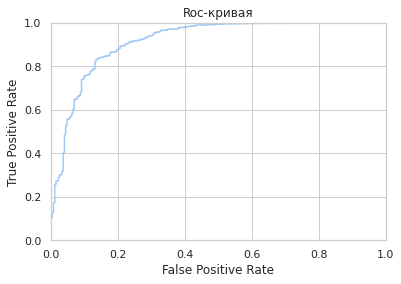

In [ ]:
probabilities_test = cbc.predict_proba(test_features)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(test_target, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-кривая')
plt.show()
auc_roc = roc_auc_score(test_target, probabilities_one_test)


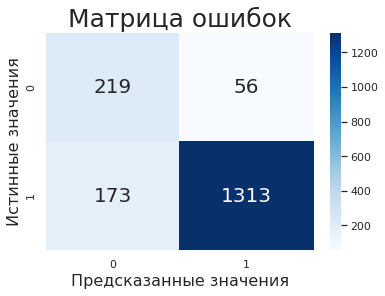

In [ ]:
conf_matrix = confusion_matrix(test_target,cbc.predict(test_features))

sns.heatmap(conf_matrix, annot=True, fmt='d',annot_kws={"fontsize":20}, cmap='Blues')
plt.ylabel('Истинные значения', fontsize=16)
plt.xlabel('Предсказанные значения', fontsize=16)
plt.title('Матрица ошибок', fontsize=25)
plt.show()

Судя по тестовой выборке из компании ушло 392 клиента (сумма в столбце "предсказанные значения", 0), модель верно предсказала уход только 219 клиентов, а 173 предсказала обратное. Для оставшихся с компанией клиентов (сумма в столбце "предсказанные значения", 1) - из 1369 клиентов, которые фактически остались в компании, модель ошиблась только в 56 случах, предсказав неверно, а 1313 клиентам модель предсказала дальнейшее сотрудничество с компанией.

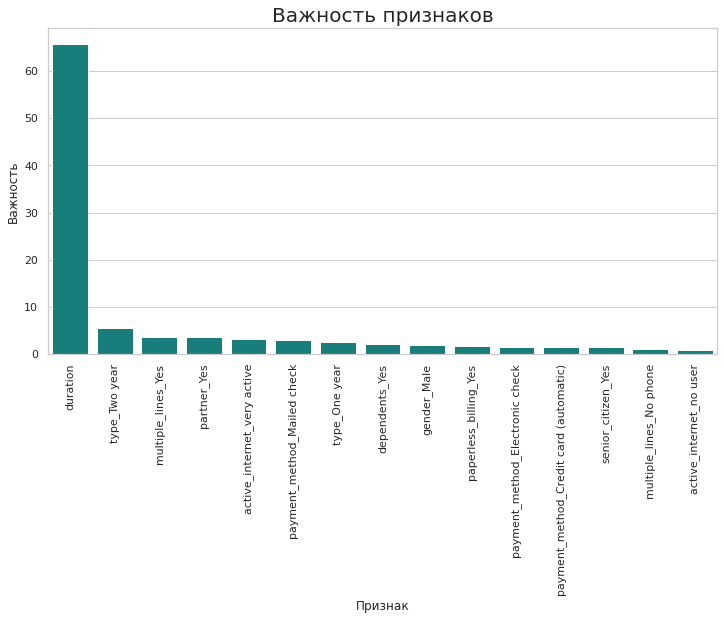

In [ ]:
importances = pd.DataFrame(data={
          'Attribute': features_train.columns,
          'Importance':cbc.best_estimator_._final_estimator.feature_importances_
      })
importances = importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize = (12,6))
sns.barplot(x=importances['Attribute'], y=importances['Importance'], color='#088E8B')
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')
plt.xlabel('Признак')
plt.ylabel('Важность')
plt.show();

Если говорить о важности признаков, то самым важным признаком оказался duration - сколько дней клиент находится в компании. На втором месте - срок контракта. Остальные не имеют такое сильное влияние.

***ОТЧЕТ***

Основная цель проекта - ***обучить модель, определяющую с точностью более 85%(на основе метрики roc_auc) желание клиента отказаться от услуг компании, чтобы не потерять его и своевременно предложить промокоды и специальные условия.***

В ходе ***преобработки данных*** мной были выполнены следующие шаги:

- Изучены все 4 начальные таблицы.
- Объединены в одну по общему столбцу customer_id.
- Столбцы приведены к единому формату по методу snake_case.
- Выявлен target на основе столбца end_date: если там стоит No, то клиент в компании(1), если там конечная дата, то он ушел(0).
- В столбце end_date No заменили на последнюю актуальную информацию - 1 февраля 2020 года и выявили новый признак duration - продолжительность пользования услугами компании в днях. Эти столбцы удалили,  так как они не нужны для обучения модели.
- В столбце total_charges нашли пропуски и заменили их месячным платежом,  так как это новые клиенты.
- В столбце senior_sitizen изменили тип данных на object,  так как это категориальный признак.
- Остальные пропуски в столбцах таблицы internet и multiple_lines заменили заглушками No internet и No phone, так как люди не пользуются интернетом или телефонией.
- Проверила отсутствие дубликатов.

***Интересное про данные:***

- Присутствует дисбаланс классов в соотношении 5:1 - больше оставшихся клиентов, чем тех, кто ушел.
- Люди, которые платят сразу на год или два - реже уходят. Месячную подписку легко отменить, а вот разрывать долгосрочный договор и возвращать деньги обратно всегда сложнее.
- Люди, которые платят наличными - реже уходят. Вероятно, так оплачивают люди выше среднего возраста и пенсионеры. Такие люди также склонны реже что-то менять в своей жизни.
- Люди, которые оплачивают автоматически с банковского перевода или кредитной карты - реже уходят. Это может быть связано с удобством или забыванием "отключить услугу".
- Чаще всего уходят люди, у которых нет дополнительных интернет-услуг.
- Среди тех, кто пользуется телефонией - чаще уходят те, у кого есть возможность подключения других каналов.
- Гендер практически не влияет на уход.
- Среди тех, кто ушел - большинство не являются пенсионерами, не имеют супругов, не имеют детей. Скорее всего, это молодые люди.
- Среди тех, кто ушел - имели больше как ежемесячные, так и суммарные платежи, чем те,кто остался.
- Их продолжительность пользования услугами была меньше(скорее всего, они имели краткосрочный контракт).
- Была построена матрица корреляции и по итогу удалены следующие признаки - monthly_charges, total_charges, internet_service и  столбцы с доп.услугами интернета. Добавлен новый признак - active_internet(very active - есть доп услуги, active - есть интернет, no user - вообще нет интернета).

***По итогу в модели остались следующие признаки:***

- Duration - продолжительность пользования услугами компании в днях.
- Target - является ли пользователь клиентом(1) компании или нет(0)
- Active_internet - насколько активен интернет пользователя(very active - есть доп услуги, active - есть интернет, no user - вообще нет интернета)
- Type - вид контракта
- Paperless_billing - есть ли электронный чек
- Payment_method - метод оплаты
- Gender - пол человека
- Senior_citizen - пенсионер или нет
- Dependents - есть ли супруг(а)
- Multiple_lines - Возможны ли дополнительные каналы телефонии

***Обучение модели***

- Обучены три модели - CatBoost, Random Forest и Logistic Regression.
- Для подбора параметров использован GridSearch.
- Лучшей моделью на тестовой выборке оказался CatBoostClassifiser с результатом метрики roc_auc = 0.91.
- Его лучшие параметры - 'cbc__depth' - 6,'cbc__iterations' - 250,'cbc__learning_rate' - 0.1,'cbc__loss_function'- 'Logloss'.

***Проверка качества модели***

- Получена дополнительная метрика accuracy - 0.87.
- Построена ROC-кривая.
- Изучена важность признаков(самым важным признаком оказался duration - продолжительность пребывания клиента в компании в днях).
- Построена confusion_matrix: модель хорошо предсказывает то, что клиент останется и похуже то, что он уйдет. Скорее всего, это связано с тем, что ушедших клиентов не так много в датасете.

***Рекомендации заказчику:***

Исходя из проведенного исследования, можно дать следующие рекомендации:

- Если пользователь пользуется Интернетом в компании, можно предложить ему дополнительные услуги к интернету на время или навсегда бесплатно.
- Если человек оплачивает помесячно, можно предложить хорошую скидку на годовой или двухгодовой тариф.
- Предлагать клиентам подключить автоплатеж с кредитной или дебетовой карты для удобства.
- Можно сделать временную скидку на платеж онлайн.
- Можно предложить выгодный комбинированный тариф - интернет + телефония.
